# BWA-MEM vs Minimap2: WGS somatic variant calling

Evaluating different variant callers with alignment data from 2 tools: [BWA-MEM](https://github.com/lh3/bwa) and [minimap2](https://github.com/lh3/minimap2). Our goal is to understand if slower BWA-MEM can be replaced in bcbio-based cancer variant calling pipleine in UMCCR.

Downloaded whole genome cancer paired datasets with curated somatic variants:

- [ICGC medulloblastoma](https://www.nature.com/articles/ncomms10001). Tumor: 103x, normal: 89x (3x downsampled), tumor purity: 95–98%.

- [COLO829 metastatic melanoma cell line](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4837349). Tumor: 81x, normal: 79x.

Analysis performed with bcbio-nextgen 1.0.8, using 2 aligners and 3 following variant callers:
- [Strelka2](https://github.com/Illumina/strelka)
- [VarDict](https://github.com/AstraZeneca-NGS/VarDict) ([filtered in bcbio](http://bcb.io/2016/04/04/vardict-filtering/), using AF threshold of 10% to avoid excessive false positive rates and runtimes)
- [Mutect2](https://software.broadinstitute.org/gatk/documentation/tooldocs/3.8-0/org_broadinstitute_gatk_tools_walkers_cancer_m2_MuTect2.php)

Ensemble calls contain variants detected with any 2 out of 3 callers above.

VCFs were evaluated with [this method](https://github.com/umccr/vcf_stuff/#variant-calling-evaluataion), which includes [normalisation](https://github.com/umccr/vcf_stuff/#vcf-normalisation) and intersection with reference truth sets using `bcftools isec`, resulting in intersection VCFs, that are loaded into this notebook using the code below.

<span id="tocheading"><b>Contents:</b></span>
<div id="toc"></div>

## Loading data

In [1]:
# Declaring basic benchmarks and callers for the study

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

benchmark_d = {
    'mb': {
        'path': 'mb/eval/batch1-{c}-annotated-{aln}_bcftools_isec',
        'callers': ['strelka2', 'vardict', 'mutect2', 'ensemble'],
        'aligners': ['bwa', 'mm2'],
    },
    'mb_0.03af': {
        'path': 'mb/eval_0.03af/{c}-{aln}_bcftools_isec',
        'callers': ['strelka2', 'vardict', 'mutect2', 'ensemble'],
        'aligners': ['mm2'],
    },
    'giab': {
        'path': 'giab/eval/UtahMormon-1-{aln}-{c}-annotated_bcftools_isec',
        'callers': ['strelka2', 'vardict', 'gatk-haplotype', 'ensemble'],
        'aligners': ['bwa', 'mm2'],
    },
    'colo': {
        'path': 'colo/eval/COLO_TGEN_{aln}-{c}-annotated_bcftools_isec',
        'callers': ['strelka2', 'vardict', 'mutect2', 'ensemble'],
        'aligners': ['bwa', 'mm2'],
    }
}
for n, b in benchmark_d.items(): 
    b['name'] = n
    b['df'] = None

benchmarks_names = ['mb', 'colo', 'giab']
benchmarks = [benchmark_d[n] for n in benchmarks_names]

In [37]:
# Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls, loading into DataFrame.
# Earlier we intersected VCFs against the truth set with 
# https://github.com/umccr/vcf_stuff/#variant-calling-evaluataion, so here we have 3 sets of VCFs 
# for each caller: 
#  - `0000.vcf` (false positives), 
#  - `0001.vcf` (false negatives), 
#  - `0002.vcf` (true positives).

from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from ngs_utils.file_utils import add_suffix
from os.path import join
import os
from collections import Counter

def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def reject_variant(rec):
    reject = False
    return reject
    
def rec_to_fields(rec, aln_name, caller):
    fields = dict()
    for tag in ['AF', 'DP', 'MQ', 'MQ0']:
        for ph in ['TUMOR', 'NORMAL']:
            v = rec.INFO.get(f'{ph}_{tag}')
            if v is not None:
                fields[f'{aln_name}_{ph}_{tag}'] = v
            elif caller == 'strelka2':
                v = rec.INFO.get(tag)
                if v is not None:
                    fields[f'{aln_name}_{ph}_{tag}'] = v

    fields[f'{aln_name}_QUAL'] = rec.QUAL

    if caller == 'vardict':
        fields[f'{aln_name}_NM'] = rec.format('NM')[main_sample_index][0]

    ann = rec.INFO.get('ANN')
    if isinstance(ann, str):  # skip decomposed fields with lost ANN
        fields['gene'] = ann.split('|')[3]

    if caller == 'strelka2':
        fields[f'{aln_name}_SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'{aln_name}_ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')
        
    fields[f'{aln_name}_PoN_CNT'] = rec.INFO.get('PoN_CNT', 0)
    return fields

def _get_vcfs(b, types=None):
    vcfs = defaultdict(dict)
    for c in b['callers']:
        for aln in b['aligners']:
            vcfs[c][aln] = dict(
                fp=join(b['path'].format(aln=aln, c=c), '0000.vcf'),
                fn=join(b['path'].format(aln=aln, c=c), '0001.vcf'),
                tp=join(b['path'].format(aln=aln, c=c), '0002.vcf'),    
            )
            if types:
                for typ in ['fp', 'fn', 'tp']:
                    if typ not in types:
                        del vcfs[c][aln][typ]
    return vcfs

def _annotate_pon(vcfs):
    fixed_vcfs = defaultdict(lambda: defaultdict(dict))
    for caller, vcf_by_aln in vcfs.items():
        for aln, vcf_by_t in vcf_by_aln.items():
            for typ, vcf in vcf_by_t.items():
                fixed_vcfs[caller][aln][typ] = vcf
                if '-pon.vcf' not in vcf:
                    vcf_pon = add_suffix(vcf, 'pon')
                    fixed_vcfs[caller][aln][typ] = vcf_pon
                    if not os.path.isfile(vcf_pon):
                        print(f'Annotating {vcf} -> {vcf_pon}')
                        !anno_pon {vcf} -o {vcf_pon} 2>&1 >/dev/null
                        fixed_vcfs[caller][aln][typ] = vcf_pon
    return fixed_vcfs

def load_vcfs(bn, types=None, annotate_pon=False, silent=False):
    if not silent: print('Loading for benchmark ' + bn)
    if not silent: print('--------------------------')
    b = benchmark_d[bn]
    vcfs = _get_vcfs(b, types)    
    if annotate_pon:
        if not silent: print('Annotating PoN')
        vcfs = _annotate_pon(vcfs)

    rows = []
    for caller in b['callers']:
        if not silent: print(f'Parsing VCFs for {caller}')
        recs_by_loc = defaultdict(lambda: [(aln, None, 'tn') for aln in b['aligners']])
        for aln_i, aln in enumerate(b['aligners']):
            for typ, vcf in vcfs[caller][aln].items():
                #print(f'  reading {vcf}')
                for rec in VCF(vcf):
                    k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                    recs_by_loc[k][aln_i] = (aln, rec, typ)            

        print(f'Analysing data for {caller}, building dataframe')
        total = 0
        passed = 0
        for (chrom, pos, ref, alt), aln_rec_typs in sorted(recs_by_loc.items(), key=lambda a: a[0]):    
            #print(aln_rec_typs)
            aln_rec_typ_d = {aln: (rec, typ) for (aln, rec, typ) in aln_rec_typs}
            assert [typ for (rec, typ) in aln_rec_typ_d.values()]
            total += 1

            x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
            if x is None:
                continue
            x += pos

            fields = dict(gene='')

            for aln, (aln_rec, aln_typ) in aln_rec_typ_d.items():
                if aln_typ in ('fp', 'tp'):
                    fields.update(rec_to_fields(aln_rec, aln, caller))

            positive_rec = next(rec for rec, typ in aln_rec_typ_d.values() if rec is not None)
            assert positive_rec is not None

            if reject_variant(positive_rec):
                continue
            passed += 1

            tricky_anno = positive_rec.INFO.get('TRICKY', '').split(',')
            tricky_anno = tuple([a for a in tricky_anno if a and a not in 
                 ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']])

            bwa, bwa_t = (aln_rec_typ_d['bwa'] if 'bwa' in aln_rec_typ_d else (None, None))
            mm2, mm2_t = (aln_rec_typ_d['mm2'] if 'mm2' in aln_rec_typ_d else (None, None))
            if bwa is not None and mm2 is not None:
                assert bwa.is_snp == mm2.is_snp, (bwa, bwa_t, mm2, mm2_t)
            row = {
                'caller': caller,
                'pos': pos,
                'label': f'{chrom}:{pos}-{ref}>{alt}', 
                'called_with_bwa': bwa_t in ('tp', 'fp'),
                'called_with_mm2': mm2_t in ('tp', 'fp'),
                'chrom': chrom,
                'x': x,
                'is_snp': positive_rec.is_snp,
                'tricky_anno': tricky_anno,
                'bwa_t': bwa_t,
                'mm2_t': mm2_t,
                'category': {
                    ('tp', 'fn'): 'unique_tp_bwa',
                    ('fn', 'tp'): 'unique_tp_mm2',
                    ('fp', 'tn'): 'unique_fp_bwa',
                    ('tn', 'fp'): 'unique_fp_mm2',  
                    ('tp', 'tp'): 'common_tp',
                    ('fp', 'fp'): 'common_fp',
                    ('fn', 'fn'): 'common_fn'
                }.get((bwa_t, mm2_t), None),
            }
            row.update(fields)
            assert pos
            rows.append(row)

        if not silent: print(f'Done parsing {total} {caller} variants, saved {passed}')
        if not silent: print()
        
    df = pd.DataFrame(rows).set_index('label', drop=False)
    if types is None:
        b['df'] = df
    return df
pass

In [36]:
load_vcfs('mb', annotate_pon=True)
pass

Loading for benchmark mb
--------------------------
Annotating PoN
Parsing VCFs for strelka2
Analysing data for strelka2, building dataframe
Done parsing 3456 strelka2 variants, saved 3456

Parsing VCFs for vardict
Analysing data for vardict, building dataframe
Done parsing 69847 vardict variants, saved 69847

Parsing VCFs for mutect2
Analysing data for mutect2, building dataframe
Done parsing 19081 mutect2 variants, saved 19081

Parsing VCFs for ensemble
Analysing data for ensemble, building dataframe
Done parsing 2383 ensemble variants, saved 2383



In [9]:
load_vcfs('mb_0.03af', annotate_pon=True)
#benchmark_d['mb_0.03af']['df'].query('caller == "strelka2"')[['mm2_TUMOR_MQ0', 'mm2_TUMOR_MQ']]
pass

Loading for benchmark mb_0.03af
--------------------------
Annotating PoN
Parsing VCFs for strelka2
Analysing data for strelka2, building dataframe
Done parsing 2679 strelka2 variants, saved 2679

Parsing VCFs for vardict
Analysing data for vardict, building dataframe
Done parsing 90992 vardict variants, saved 90992

Parsing VCFs for mutect2
Analysing data for mutect2, building dataframe
Done parsing 15898 mutect2 variants, saved 15898

Parsing VCFs for ensemble
Analysing data for ensemble, building dataframe
Done parsing 3528 ensemble variants, saved 3528



In [29]:
load_vcfs('colo', annotate_pon=True)
pass

Loading for benchmark colo
--------------------------
Annotating PoN
Parsing VCFs for strelka2
Analysing data for strelka2, building dataframe
Done parsing 51163 strelka2 variants, saved 51163

Parsing VCFs for vardict
Analysing data for vardict, building dataframe
Done parsing 87555 vardict variants, saved 87555

Parsing VCFs for mutect2
Analysing data for mutect2, building dataframe
Done parsing 49600 mutect2 variants, saved 49600

Parsing VCFs for ensemble
Analysing data for ensemble, building dataframe
Done parsing 45221 ensemble variants, saved 45221



In [ ]:
load_vcfs('giab')
pass

<br>
<br>


## Venn diagrams for cross-comparison

In [39]:
# Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. 
# common calls. Drawing summary Venn diagrams for each caller and aligner:
# 
# mm2/bwa ensemble    tp-snp  tp-ind  fp-snp  fp-ind  fn-snp  fn-ind 
# mm2/bwa strelka2    --//--  --//--
# mm2/bwa mutect2     --//--
# mm2/bwa vardict
# v/s/m bwa  
# v/s/m mm2            
  
from matplotlib_venn import venn2, venn3
from matplotlib import gridspec
import itertools

def plot_venn(bn, df=None):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']
    figsize = (15, 15)

    event_types = [True, False]  # SNP, non-SNP
    
    # 2-way BWA vs Minimap2, one raw for each caller
    for clr_i, clr in enumerate(b['callers']):
        fig = plt.figure(figsize=figsize)
        plt.title(f'BWA vs minimap2 calls for {clr}')
        grid = gridspec.GridSpec(1, len(event_types)*3)
        for is_snp_i, is_snp in enumerate(event_types):
            lbl = 'SNP' if is_snp else 'Ind'
            for typ_i, typ in enumerate(['tp', 'fp', 'fn']):
                ax = plt.subplot(grid[len(event_types)*typ_i + is_snp_i])
                sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
                        for aln in ['bwa', 'mm2']]                
                venn2(sets, set_labels=['bwa', 'mm2'], ax=ax)
                ax.set_title(f'{clr}, {lbl}, {typ}')
        
    # 3-way strelka2 vs mutect vs vardict, one raw for each aligner
    clrs = [c for c in b['callers'] if c != 'ensemble']   
    for aln in ['bwa', 'mm2']:
        fig = plt.figure(figsize=figsize)
        plt.title(f'Callers against each other for {aln}')
        grid = gridspec.GridSpec(1, len(event_types)*3)
        for is_snp_i, is_snp in enumerate(event_types):
            lbl = 'SNP' if is_snp else 'Ind'
            for typ_i, typ in enumerate(['tp', 'fp', 'fn']):
                ax = plt.subplot(grid[len(event_types)*typ_i + is_snp_i])
                sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
                        for clr in clrs]                
                venn3(sets, set_labels=clrs, ax=ax)
                ax.set_title(f'{aln}, {lbl}, {typ}')

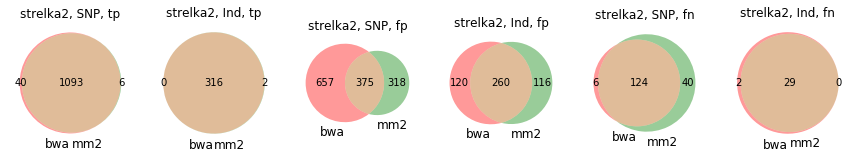

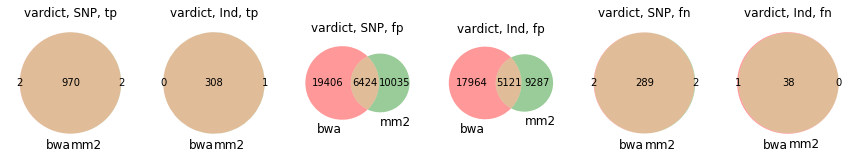

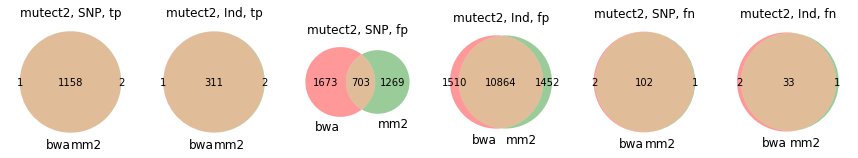

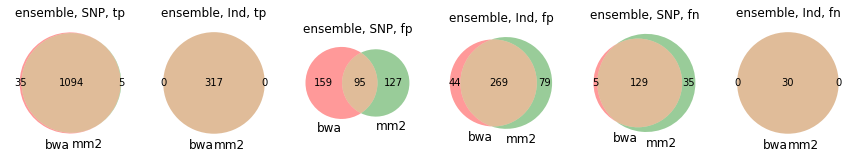

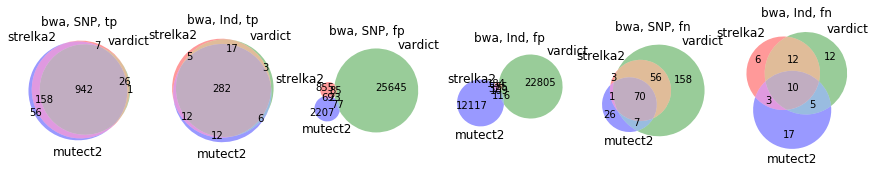

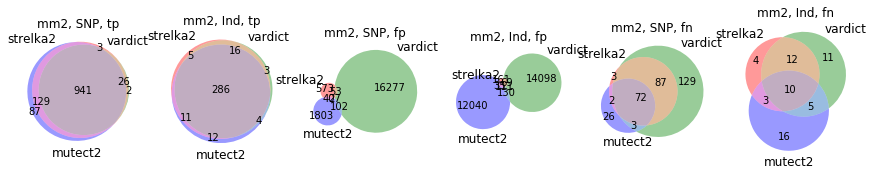

In [14]:
plot_venn('mb')

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning



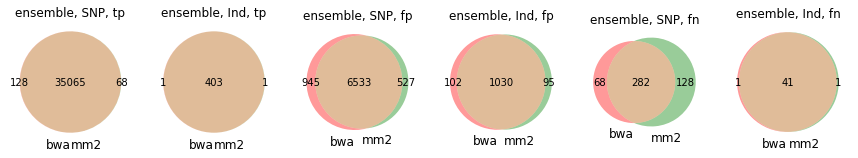

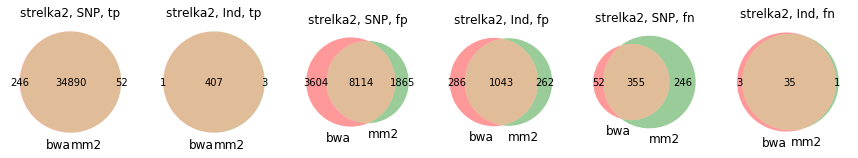

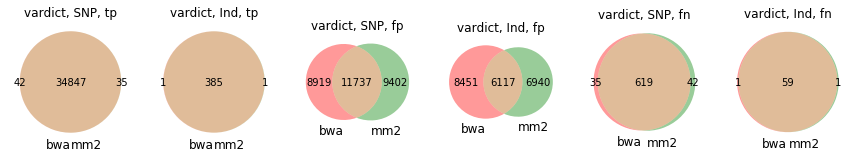

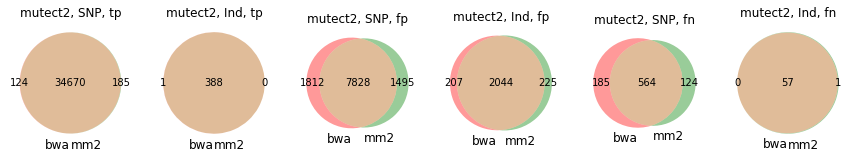

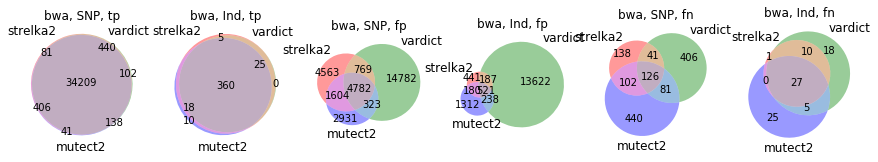

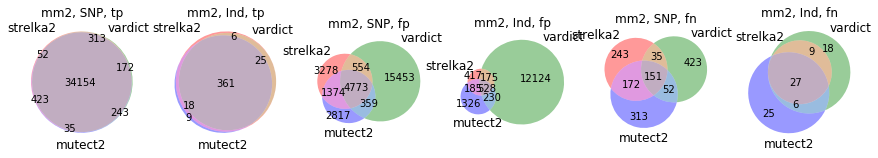

In [289]:
plot_venn('colo')

Analysing data for strelka2, building dataframe
Analysing data for vardict, building dataframe
Analysing data for mutect2, building dataframe
Analysing data for ensemble, building dataframe


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area



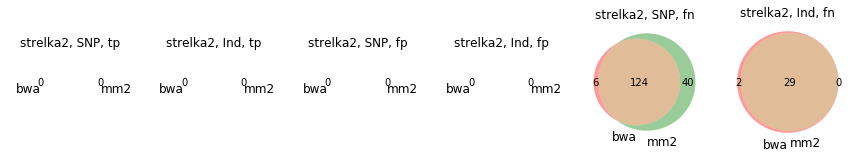

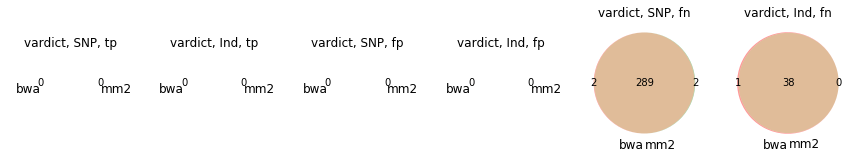

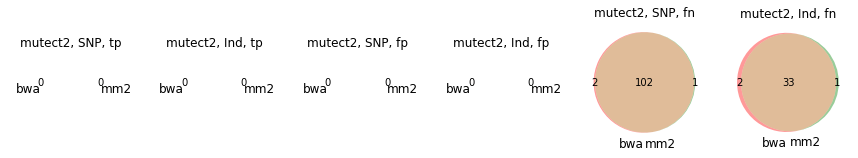

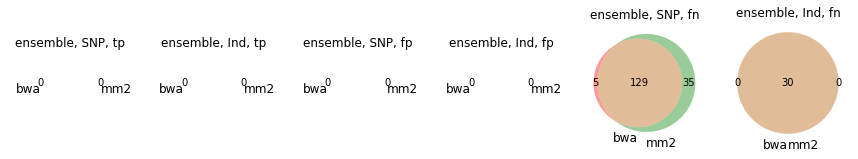

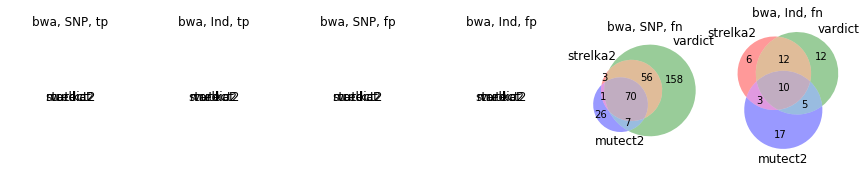

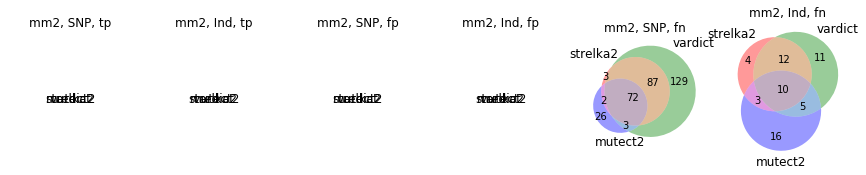

In [40]:
# Plotting only MB false negatives
plot_venn('mb', load_vcfs('mb', ['fn'], silent=True))

Loading for benchmark giab
--------------------------
Parsing VCFs for ensemble
  reading giab/eval/UtahMormon-1-bwa-ensemble-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-ensemble-annotated_bcftools_isec/0001.vcf
Analysing data for ensemble, building dataframe
Done parsing 14867 ensemble variants, saved 14867

Parsing VCFs for strelka2
  reading giab/eval/UtahMormon-1-bwa-strelka2-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-strelka2-annotated_bcftools_isec/0001.vcf
Analysing data for strelka2, building dataframe
Done parsing 21169 strelka2 variants, saved 21169

Parsing VCFs for vardict
  reading giab/eval/UtahMormon-1-bwa-vardict-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-vardict-annotated_bcftools_isec/0001.vcf
Analysing data for vardict, building dataframe
Done parsing 58246 vardict variants, saved 58246

Parsing VCFs for gatk-haplotype
  reading giab/eval/UtahMormon-1-bwa-gatk-haplotype-annotated_bcftools

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area



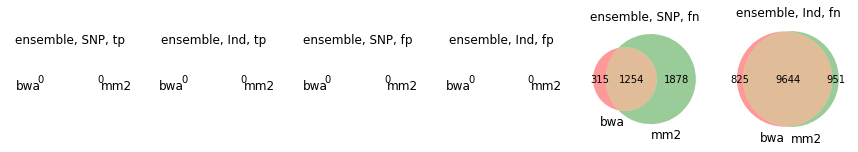

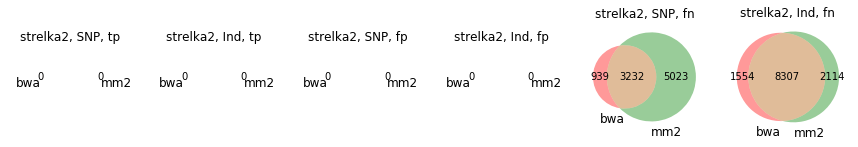

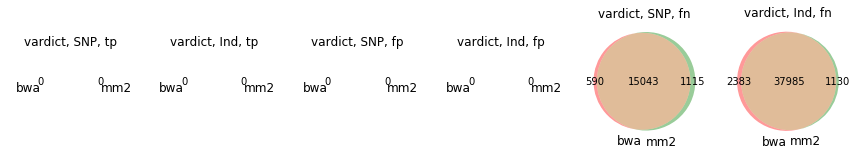

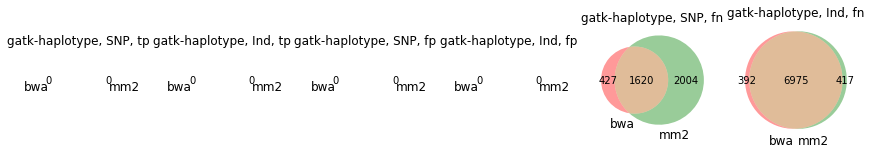

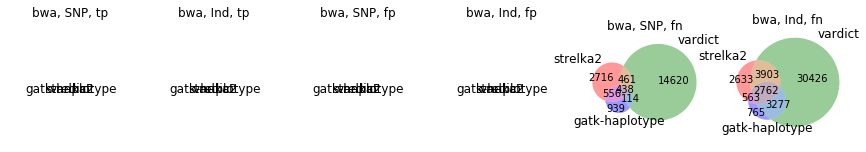

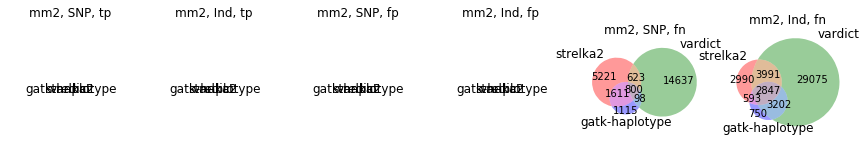

In [224]:
plot_venn('giab', load_vcfs('giab', ['fn']))

<br>
<br>


##  Pretty tables

In [10]:
# Calculating evaluation statistics (recall, precision, F1, etc) to display in pretty table

import seaborn as sns
import warnings
import itertools

def _f_measure(b, prec, recall):
    assert (b**2 * prec + recall) != 0, (b, prec, recall)
    return (1 + b**2) * prec * recall / (b**2 * prec + recall)

def _cnt_stats(cdf_c, aln):
    snp = dict()
    ind = dict()
    
    snp['TP'] = len(cdf_c.query(f'{aln}_t == "tp" & is_snp'))
    ind['TP'] = len(cdf_c.query(f'{aln}_t == "tp" & not is_snp'))
    snp['FN'] = len(cdf_c.query(f'{aln}_t == "fn" & is_snp'))
    ind['FN'] = len(cdf_c.query(f'{aln}_t == "fn" & not is_snp'))
    snp['FP'] = len(cdf_c.query(f'{aln}_t == "fp" & is_snp'))
    ind['FP'] = len(cdf_c.query(f'{aln}_t == "fp" & not is_snp'))
    
    snp['P']      = snp['TP'] + snp['FP']
    snp['Prec']   = snp['TP'] / snp['P'] if snp['P'] else 0
    snp['T']      = snp['TP'] + snp['FN']
    snp['Recall'] = snp['TP'] / snp['T'] if snp['T'] else 0

    ind['P']      = ind['TP'] + ind['FP']
    ind['Prec']   = ind['TP'] / ind['P'] if ind['P'] else 0
    ind['T']      = ind['TP'] + ind['FN']
    ind['Recall'] = ind['TP'] / ind['T'] if ind['T'] else 0

    snp['F1'] = _f_measure(1, snp['Prec'], snp['Recall'])
    snp['F2'] = _f_measure(2, snp['Prec'], snp['Recall'])
    ind['F1'] = _f_measure(1, ind['Prec'], ind['Recall'])
    ind['F2'] = _f_measure(2, ind['Prec'], ind['Recall'])
    return snp, ind
    
def make_stats(bn, query_fmt=None, recalc_ensemble=False, add_truth=False):
    stats_by_sample = dict()
    #bns = ([bn] if isinstance(bn, str) else bn) if bn else benchmarks_names
    print(f'Benchmark: {bn}' + (f', filtered: {query_fmt}' if query_fmt else ''))
    b = benchmark_d[bn]
    df = b['df']
    for aln in b['aligners']:
        if query_fmt:
            df_c = df.copy()
            rej = df_c.query('not ' + query_fmt.format(**locals()))
            df_c = df_c.drop(rej.query(f'{aln}_t == "fp"').index)
            for i in rej.query(f'{aln}_t == "tp"').index:
                df_c.loc[i,f'{aln}_t'] = 'fn'
        else:
            df_c = df

        lbls_called_by = dict() 
        for clr in b['callers']:
            cdf_c = df_c.query(f'caller == "{clr}"')
            stats_by_sample[f'{aln} {clr}'] = _cnt_stats(cdf_c, aln)                
            if clr != 'ensemble':
                lbls_called_by[clr] = set(cdf_c.query(f'{aln}_t == "tp" | {aln}_t == "fp"').index)

        if recalc_ensemble:
            ensemble_lbls = set()
            for c1, c2 in itertools.combinations(lbls_called_by, 2):
                ensemble_lbls |= (lbls_called_by[c1] & lbls_called_by[c2])
            ensemble_rej = set().union(*lbls_called_by.values()) - ensemble_lbls
            edf = df_c.query(f'caller == "ensemble"').copy()
            for i in (ensemble_rej & set(edf.index)):
                if edf.loc[i,f'{aln}_t'] == 'tp':
                    edf.loc[i,f'{aln}_t'] = 'fn'
                if edf.loc[i,f'{aln}_t'] == 'fp':
                    edf.loc[i,f'{aln}_t'] = 'tn'
            stats_by_sample[f'ens_re {aln}'] = _cnt_stats(edf, aln)  
    
    if add_truth:
        some_aln = b["aligners"][0]
        some_clr = b["callers"][0]
        truth_snp = len(df.query(f'({some_aln}_t in ["fp", "fn"]) and caller=="{some_clr}" and is_snp'))
        truth_ind = len(df.query(f'({some_aln}_t in ["fp", "fn"]) and caller=="{some_clr}" and not is_snp'))
        stats_by_sample[f'{bn} truth'] = {'T': truth_snp}, {'T': truth_ind}
    return stats_by_sample

In [11]:
# Printing statistics in a pretty table

import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl
import seaborn as sns

max_and_min = {
    ('SNP', 'Prec'):     (0.6, 1),
    ('INDEL', 'Prec'):   (0.6, 1),
    ('SNP', 'Recall'):   (0.8, 1),
    ('INDEL', 'Recall'): (0.8, 1),
    ('SNP', 'F2'):       (0,   1),
    ('INDEL', 'F2'):     (0,   1),
}

def stats_to_df(stat_by_sname):
    metircs = ['FP' , 'FN' , 'Recall', 'Prec', 'F2']
    idx = pd.MultiIndex.from_arrays([
            ['Sample'] + ['SNP']*len(metircs) + ['INDEL']*len(metircs), 
            [''] + metircs + metircs],
        names=['', 'Sample'])
    data = []
    s_truth = i_truth = None
    for sname, (snp, ind) in stat_by_sname.items():
        d = {('Sample', ''): sname}
        for lbl, st in [('SNP', snp), ('INDEL', ind)]:
            for m in metircs:
                d[(lbl, m)] = st.get(m, m['T'] if m == 'TP' else (0 if m in ['FP', 'FN'] else 1.0))
        data.append(d)
    return pd.DataFrame(data, columns=idx)

def _print_stats_txt(stats_by_sample):
    df = stats_to_df(stats_by_sample)
    df = df.set_index(df[('Sample', '')].values).drop([('Sample', '')], axis=1) 
    with pd.option_context(
            'display.max_rows', None,
            'display.max_columns', None,
            'display.width', None,
            'display.float_format', lambda v: '{:,.2f}%'.format(100.0*v)
        ):
        print(df.to_string(index=True))

def display_stats(stats_by_sample):
    def _highlight_max(vals):
        BLUE_HUE = 211
        RED_HUE = 1
        MIN_BLUE, MAX_BLUE = 50, 100  # colors for minv..maxv
        MIN_RED, MAX_RED = 40, 100    # colors for 0..minv
        styles = []
        for v in vals:
            style = ''
            if vals.name in max_and_min:
                minv, maxv = max_and_min[vals.name]
                if v > minv:  
                    k = (v - minv) / (maxv - minv) 
                    l = MAX_BLUE - k * (MAX_BLUE - MIN_BLUE)
                    bg_style = f'background-color: hsl({BLUE_HUE}, 100%, {l}%)'
                    text_clr = 'white' if l < 70 else 'black'
                else:
                    k = (v - 0) / (minv - 0) 
                    l = MIN_RED + k * (MAX_RED - MIN_RED)
                    bg_style = f'background-color: hsl({RED_HUE}, 100%, {l}%)'
                    text_clr = 'white' if l < 70 else 'black'
                style = f'{bg_style}; color: {text_clr}; '
            styles.append(style)
        return styles

    df = stats_to_df(stats_by_sample)
    df = df.set_index(df[('Sample', '')].values).drop([('Sample', '')], axis=1) 
    return df.style\
        .format(lambda v: ('{:,.2f}%' if v !=1 else '{}%').format(100.0*v) if isinstance(v, float) else v)\
        .apply(_highlight_max)\
        .set_table_styles([dict(selector='td', props=[('padding', '1px 4px 1px 4px')]),
                           dict(selector='th', props=[('text-align', 'left')]), 
                           dict(selector='tr', props=[('line-height', '10px')]),
                           dict(selector='td', props=[('font-size', '14px')]),
                          ])

In [13]:
display_stats(make_stats('mb'))

Benchmark: mb


In [12]:
display_stats(make_stats('mb_0.03af'))    # By default, VarDict restricted to AF>10%. Here, allowing AF>3%

Benchmark: mb_0.03af


In [ ]:
display_stats(make_stats('mb', '{aln}_PoN_CNT == 0'))
display_stats(make_stats('mb', '{aln}_TUMOR_AF > 0.05'))
display_stats(make_stats('mb', '{aln}_TUMOR_AF > 0.1'))
display_stats(make_stats('mb', '{aln}_TUMOR_AF > 0.2'))

In [30]:
display_stats(make_stats('colo'))

Benchmark: colo


In [ ]:
display_stats(make_stats('colo', '{aln}_PoN_CNT == 0'))

<br>
<br>


##  Exploring Strelka2+Minimap2 FN in detail

In [ ]:
# Getting Minimap2 data for unique Strelka2+Minimap2 FN
tp_bwa_strelka_by_bn = {
    bn: benchmark_d[bn]['df'].query('caller == "strelka2" & is_snp & bwa_t == "tp" & mm2_t != "tp"')
    for bn in ['mb', 'colo']
}

In [115]:
# Getting some true positives for control group
chr21_tp_strelka_by_bn = dict()
chr21_tp_strelka_by_bn['mb'] = benchmark_d['mb']['df'].query('caller == "strelka2" & is_snp & bwa_t == "tp" & mm2_t == "tp" & chrom == "1"')
chr21_tp_strelka_by_bn['colo'] = benchmark_d['colo']['df'].query('caller == "strelka2" & is_snp & bwa_t == "tp" & mm2_t == "tp" & chrom == "1" & pos % 20 == 0')
print([len(c) for c in chr21_tp_strelka_by_bn.values()])
for bn, df in chr21_tp_strelka_by_bn.items():
    chrom_pos = list(zip(df['chrom'].tolist(), df['pos'].tolist()))
    with open(f'strelka2_snp_fp/{bn}_strelka2_snp_fp.bed', 'w') as f:
        for chrom, pos in chrom_pos:
            f.write(f'{chrom}\t{pos-1}\t{pos}\n')

[83, 83]
[  2878240  17016120  23112220  33407220  35090540  36386360  48312460
  49895040  55476200  56182520  57270040  60112960  60967440  63881140
  73455120  74391140  76480080  83069660  83489600  83519780  83766200
  92171160  94263280  96545200  99094800 101398620 102998480 103284000
 106978600 107438880 112641620 117839700 149658720 156019640 158309600
 161222060 164318680 164897920 164950980 167542820 175473860 181571120
 181842720 182460160 183475580 184997480 186989100 188707540 190650220
 191022820 192523080 193648440 195028340 197697940 198654180 203055000
 203952480 209059600 212645720 215357360 217871660 218583400 218945620
 220255880 220787440 221964280 222037940 226724700 228186220 233099360
 233339700 234240960 238551160 239586460 241283860 241614940 243720180
 245921580 247233300 248216480 248520860 248531980 248604020]


In [116]:
# Filling up missing Strelka2+Minimap2-FN VCF tags
import tabix

for bn, df in tp_bwa_strelka_by_bn.items():
    chrom_pos_label = list(zip(df['chrom'].tolist(), df['pos'].tolist(), df.index))
    print(f'FN mm2 positions called with bwa, total {len(chrom_pos)} in {bn}')
    
    bdir = 'strelka2_snp_uniq_fn'
    bed = f'{bdir}/{bn}_strelka_snp_uniq_fn.bed'
    with open(bed, 'w') as f:
        for chrom, pos, label in chrom_pos_label:
            try:
                pos = int(pos)
            except:
                print(label)
                raise
            f.write(f'{chrom}\t{pos-1}\t{pos}\t{label}\n')
    if bn == 'mb':
        inp_vcf = 'mb/batch1-strelka2-annotated-mm2.vcf.gz'
    if bn == 'colo':
        inp_vcf = 'colo/COLO_TGEN_mm2-strelka2-annotated.vcf.gz'

    out_vcf = f'{bdir}/{bn}_strelka_snp_uniq_fn.annotated.vcf.gz'
    
    !bcftools view {inp_vcf} -R {bed} -Oz -o {bdir}/{bn}_strelka_snp_uniq_fn.vcf.gz
    !pcgr_prep {bdir}/{bn}_strelka_snp_uniq_fn.vcf.gz | bgzip -c > {out_vcf}
    !tabix {out_vcf}    

for bn, df in tp_bwa_strelka_by_bn.items():
    vcfp = f'{bdir}/{bn}_strelka_snp_uniq_fn.annotated.vcf.gz'
    chrom_pos_label = list(zip(df['chrom'].tolist(), df['pos'].tolist(), df.index))
    print(f'Filling up mm2 fields in {bn} from VCF')
    vcf = VCF(vcfp)
    for rec in vcf:
        fs = rec_to_fields(rec, 'mm2', 'strelka2')
        label = f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}'
        if label in df.index:
            for k, v in fs.items():
                df.loc[label,k] = v

FN mm2 positions called with bwa, total 83 in mb
FN mm2 positions called with bwa, total 83 in colo
Filling up mm2 fields in mb from VCF


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Filling up mm2 fields in colo from VCF


In [117]:
# Getting only strelka2 unique FN SNPs
small_dfs = dict()
for bn in ['mb', 'colo']:
    print(bn)
    v = VCF(f'strelka2_snp_uniq_fn/{bn}_strelka_snp_uniq_fn.vcf.gz')
    labels = list(set([f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}' for rec in v]))
    sdf = benchmark_d[bn]['df']
    #sdf['label'].isin(labels)
    print(len(labels))
    #print(set(sdf['label'].values) & set(labels))
    #print(len(sdf[sdf['label'].isin(labels)]))
    sdf = sdf[sdf.index.isin(labels)]
    print(len(sdf))
    small_dfs[bn] = sdf

mb
40
160
colo
231
918


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")
/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")
/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


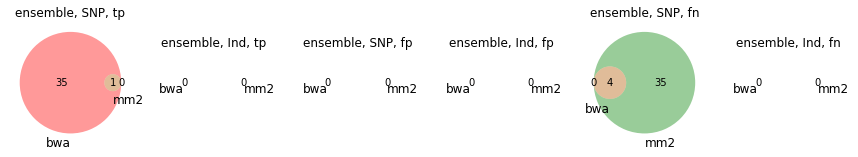

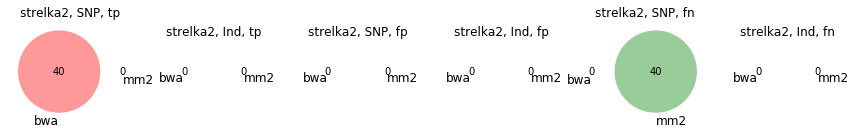

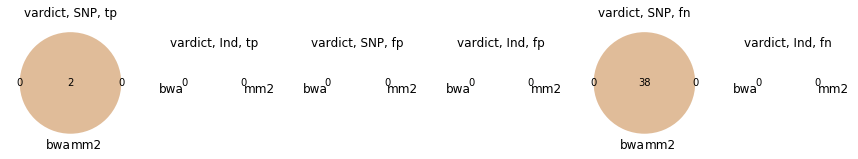

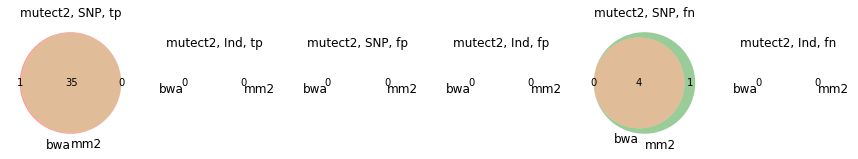

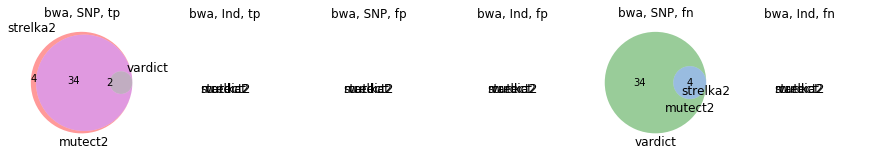

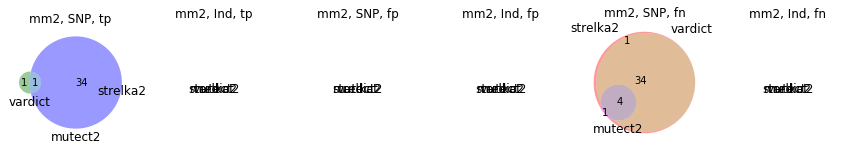

In [50]:
plot_venn('mb', small_dfs['mb'])

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:53: UserWarning:

Circle A has zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:57: UserWarning:

Circle B has zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning:

Circle C has zero area



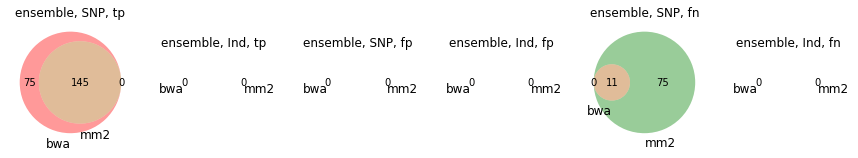

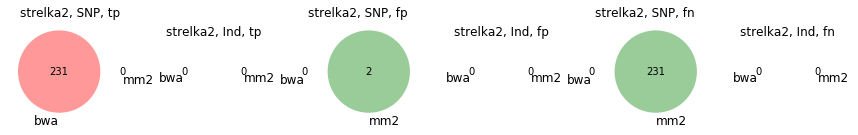

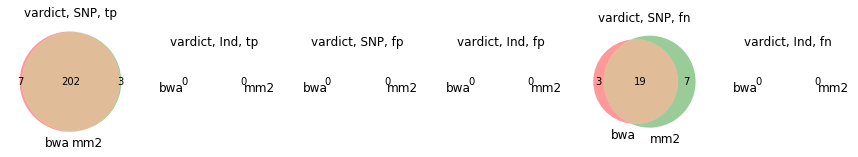

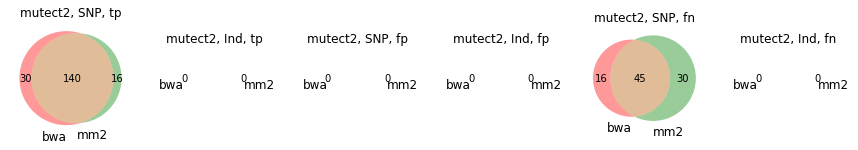

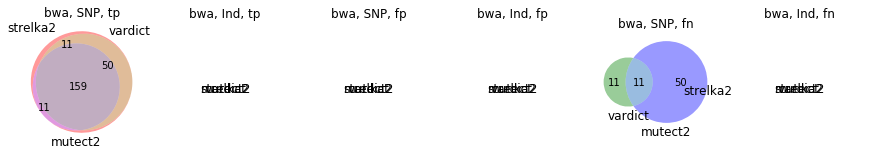

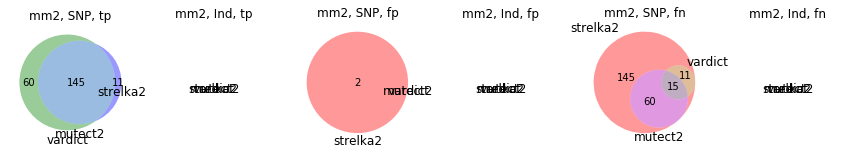

In [279]:
plot_venn('colo', small_dfs['colo'])

In [157]:
# Calcualting AS (alignment scores) at Strelka2+Minimap2 SNP FN and filling up the df:
import pysam
import pprint

tags = ['AS', 'XS', 'NM', 'MQ']

# To get BAMs, execute locally:
"""
cd strelka2_snp_fp
scp -r mb_strelka2_snp_fp.bed spa:/data/cephfs/punim0010/projects/Saveliev_ICGC_MB
scp -r colo_strelka2_snp_fp.bed spa:/data/cephfs/punim0010/projects/Saveliev_COLO829_Craig
"""

# Then on Spartan:
"""
cd /data/cephfs/punim0010/projects/Saveliev_COLO829_Craig

~/bin/sambamba slice bcbio_mm2/final/COLO829_TGEN_mm2/COLO829_TGEN_mm2-ready.bam -L colo_strelka2_snp_fp.bed -o colo_mm2_tumor_strelka2_snp_fp.bam
~/bin/sambamba sort colo_mm2_tumor_strelka2_snp_fp.bam -o colo_mm2_tumor_strelka2_snp_fp.s.bam
mv colo_mm2_tumor_strelka2_snp_fp.s.bam colo_mm2_tumor_strelka2_snp_fp.bam
mv colo_mm2_tumor_strelka2_snp_fp.s.bam.bai colo_mm2_tumor_strelka2_snp_fp.bam.bai

~/bin/sambamba slice bcbio_bwa/final/COLO829_TGEN_bwa/COLO829_TGEN_bwa-ready.bam -L colo_strelka2_snp_fp.bed -o colo_bwa_tumor_strelka2_snp_fp.bam
~/bin/sambamba sort colo_bwa_tumor_strelka2_snp_fp.bam -o colo_bwa_tumor_strelka2_snp_fp.s.bam
mv colo_bwa_tumor_strelka2_snp_fp.s.bam colo_bwa_tumor_strelka2_snp_fp.bam
mv colo_bwa_tumor_strelka2_snp_fp.s.bam.bai colo_bwa_tumor_strelka2_snp_fp.bam.bai

cd /data/cephfs/punim0010/projects/Saveliev_ICGC_MB

~/bin/sambamba slice mb_workflow/final/tumor_downsample/tumor_downsample-ready.bam -L mb_strelka2_snp_fp.bed -o mb_mm2_tumor_strelka2_snp_fp.bam
~/bin/sambamba sort mb_mm2_tumor_strelka2_snp_fp.bam -o mb_mm2_tumor_strelka2_snp_fp.s.bam
mv mb_mm2_tumor_strelka2_snp_fp.s.bam mb_mm2_tumor_strelka2_snp_fp.bam
mv mb_mm2_tumor_strelka2_snp_fp.s.bam.bai mb_mm2_tumor_strelka2_snp_fp.bam.bai

~/bin/sambamba slice mb_workflow_bwa/final/tumor_downsample/tumor_downsample-ready.bam -L mb_strelka2_snp_fp.bed -o mb_bwa_tumor_strelka2_snp_fp.bam
~/bin/sambamba sort mb_bwa_tumor_strelka2_snp_fp.bam -o mb_bwa_tumor_strelka2_snp_fp.s.bam
mv mb_bwa_tumor_strelka2_snp_fp.s.bam mb_bwa_tumor_strelka2_snp_fp.bam
mv mb_bwa_tumor_strelka2_snp_fp.s.bam.bai mb_bwa_tumor_strelka2_snp_fp.bam.bai
"""

# Then locally:
"""
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_ICGC_MB/mb_bwa_tumor_colo_strelka2_snp_fp.bam .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_ICGC_MB/mb_bwa_tumor_colo_strelka2_snp_fp.bam.bai .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_ICGC_MB/mb_mm2_tumor_colo_strelka2_snp_fp.bam .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_ICGC_MB/mb_mm2_tumor_colo_strelka2_snp_fp.bam.bai .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_COLO829_Craig/colo_bwa_tumor_colo_strelka2_snp_fp.bam .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_COLO829_Craig/colo_bwa_tumor_colo_strelka2_snp_fp.bam.bai .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_COLO829_Craig/colo_mm2_tumor_colo_strelka2_snp_fp.bam .
scp -r spa:/data/cephfs/punim0010/projects/Saveliev_COLO829_Craig/colo_mm2_tumor_colo_strelka2_snp_fp.bam.bai .
"""

def calc_sam_tags(df_by_bn, fname='strelka2_snp_uniq_fn'):
    tag_d = defaultdict(list)

    for bn, df in df_by_bn.items():
        for aln in ['bwa', 'mm2']:
            print(f'Filling up SAM stats for {bn}, {aln}')
            samfile = pysam.AlignmentFile(f'{fname}/{bn}_{aln}_tumor_{fname}.bam', 'rb')
            for label, chrom, pos in zip(df.index, df['chrom'], df['pos']):
                if np.isnan(pos):
                    continue
                for i, read in enumerate(samfile.fetch(chrom, pos-1, pos)):
                    for tag in tags:
                        if tag == 'MQ':
                            val = read.mapping_quality
                        elif read.has_tag(tag):
                            val = read.get_tag(tag)
                        else:
                            #print(f'{chrom}:{pos}: read does not have {tag} tag: {read.query_name}')
                            continue
                        tag_d[(bn, aln, tag, (chrom, pos))].append(val)
    print(np.mean(tag_d[('mb', 'bwa', 'MQ', ('1', 50854774))]))
#                 for tag in tags:
#                     try:
#                         m = np.mean(tag_d[(bn, aln, tag, (chrom, pos))])
#                     except:
#                         print(f'Cannot calc {tag} mean at {chrom}:{pos}')
#                     else:
#                         df.loc[label, f'{aln}_TUMOR_SAM_{tag}'] = np.mean(tag_d[(bn, aln, tag, (chrom, pos))])

print('Calculating tags for strelka2_snp_uniq_fn')
calc_sam_tags(tp_bwa_strelka_by_bn, 'strelka2_snp_uniq_fn')
# print('Calculating tags for strelka2_snp_fp')
# calc_sam_tags(chr21_tp_strelka_by_bn, 'strelka2_snp_fp')

Calculating tags for strelka2_snp_uniq_fn
Filling up SAM stats for mb, bwa
Filling up SAM stats for mb, mm2
Filling up SAM stats for colo, bwa
Filling up SAM stats for colo, mm2
59.8974358974


label
1:50854774-T>C      0.081081
1:98616176-G>A      0.054054
10:94191590-C>T     0.036364
10:96243453-A>T     0.043011
10:112372768-C>T    0.049587
11:105797546-G>A    0.041667
12:39052772-G>T     0.069307
12:63211290-A>G     0.080460
12:88107680-G>T     0.072464
13:61224751-T>A     0.050000
15:35349271-A>T     0.080000
15:35401362-A>T     0.080000
16:28513986-C>A     0.028736
17:17267700-C>G     0.092308
18:38058775-G>T     0.062500
19:2261283-G>T      0.078571
2:17778613-T>C      0.031250
2:24686755-G>A      0.036036
2:154530079-A>G     0.058823
4:15555852-G>T      0.030303
4:20019882-G>C      0.041667
4:26588036-C>G      0.052083
4:61209147-A>C      0.032520
4:70423735-C>A      0.029630
4:72973301-G>C      0.054545
4:99687941-A>G      0.050725
4:102327305-C>T     0.540984
4:105829403-C>T     0.036364
5:23482440-G>A      0.036585
5:67315183-A>T      0.050000
6:18217150-G>A      0.030303
6:22015897-G>A      0.058823
6:143487818-C>T     0.047619
8:27599063-C>T      0.074074
8:495840

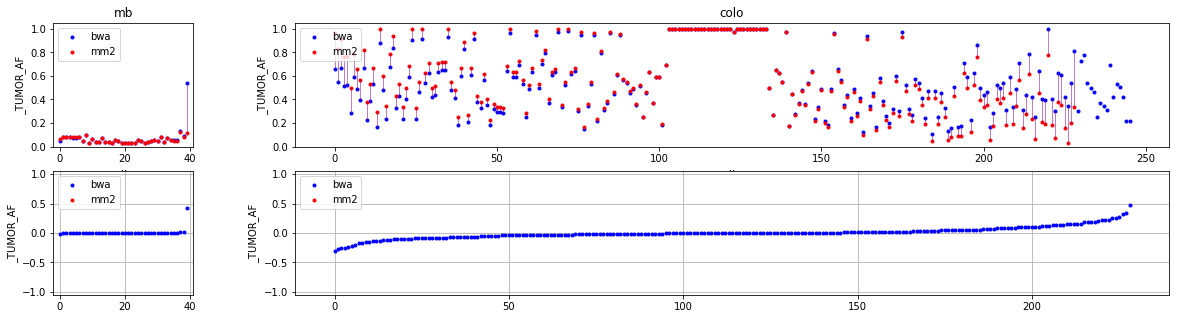

In [159]:
# For unique Strelka2+BWA FP, plotting differences with minimap2
from matplotlib import gridspec
import pandas as pd
import numpy as np
import math

bright_colors = ['blue', 'red', 'green']
pale_colors = ['lightblue', 'pink', 'lightgreen']

def plot_tags(df_by_bn, only_stats=False):
    for field, ylim in [
            ('_TUMOR_SAM_AS',   (0, 300  )), 
            ('_TUMOR_SAM_XS',   None     ), 
            ('_TUMOR_SAM_NM',   None     ), 
            ('_TUMOR_SAM_MQ',   None     ), 
            ('_TUMOR_MQ',       (0, 70   )),
            ('_TUMOR_MQ0',      (0, 70   )),
            ('_TUMOR_AF',       (0, 1.05 )),
            ('_TUMOR_DP',       (0, 200  )), 
            ('_ReadPosRankSum', (-10, 10 )),
            ('_SomaticEVS',     None     ),
        ]:
        if not only_stats:
            fig = plt.figure(figsize=(20, 5))
            grid = gridspec.GridSpec(2, 2, width_ratios=[40, 250])

        bwa_d = dict()
        mm2_d = dict()
        for i, (bn, df) in enumerate(df_by_bn.items()):
#             for aln in ['bwa', 'mm2']:
#                 print(df[aln + field])
        
            if not only_stats:
                ax = plt.subplot(grid[i], label=bn)
                ax_diff = plt.subplot(grid[2+i], label=bn)
            values = [df[aln + field].reset_index(drop=True).values for aln in ['bwa', 'mm2']]
            diffs = [v1 - v2 for v1, v2 in zip(*values)]
            values.append([d if not math.isnan(d) else None for d in diffs])
            value_triplets = list(zip(*values))
            value_triplets = sorted(value_triplets, key=lambda v: v[2] if v[2] is not None else math.inf)
    #         if i == 1 and field == '_TUMOR_DP':
    #             for t in value_triplets:
    #                 print(t)
            values = list(zip(*value_triplets))

            if not only_stats:
                for j, aln in enumerate(['bwa', 'mm2']):
                    ax.plot(values[j], '.', c=bright_colors[j], label=f'{aln}')
                ax_diff.plot(values[2], '.', c='blue', label=f'bwa - mm2')

#             diffs = [x for x in diffs if x is not None and not math.isnan(x)]
#             if diffs:
#                 m = np.mean(diffs)
#                 if not math.isnan(m):
#                     diff_d[bn] = m
#                     abs_diff_d[bn] = np.mean([abs(x) for x in diffs])
            vs = [x for x in values[0] if not math.isnan(x)]
            if vs:
                bwa_d[bn] = np.mean(vs)
            vs = [x for x in values[1] if not math.isnan(x)]
            if vs:
                mm2_d[bn] = np.mean(vs)

            if not only_stats:
                for x, (v1, v2, diff) in enumerate(value_triplets):
                    line_clr = None
                    if v1 is not None and v2 is not None:
                        line_clr = 'purple'
                    elif d1 is not None:
                        line_clr = 'red'
                    elif d2 is not None:
                        line_clr = 'blue'
                    ax.plot([x, x], [v1, v2], '-', c=line_clr, lw=0.5)

                ax.set_xlabel('x')
                ax.set_ylabel(field)
                ax.set_title(label=bn)
                if ylim:
                    ax.set_ylim(ylim)
                ax.legend(*ax.get_legend_handles_labels(), loc=2)

                ax_diff.set_label('x')
                ax_diff.set_ylabel(field)
                if ylim:
                    ax_diff.set_ylim((-ylim[1], ylim[1]))
                ax_diff.legend(*ax.get_legend_handles_labels(), loc=2)

                plt.grid()

    #     md = diff[(bn, field)]
    #     amd = abs_diff[(bn, field)]
        print(f'{field:20}' + 
              (f'{bwa_d["mb"]:.2f}' if "mb" in bwa_d else '-') + '/' +
              (f'{mm2_d["mb"]:.2f}' if 'mb' in mm2_d else '-') + '   ' +
              (f'{bwa_d["colo"]:.2f}' if "colo" in bwa_d else '-') + '/' +
              (f'{mm2_d["colo"]:.2f}' if 'colo' in mm2_d else '-')
              )
              
plot_tags(tp_bwa_strelka_by_bn, only_stats=False)

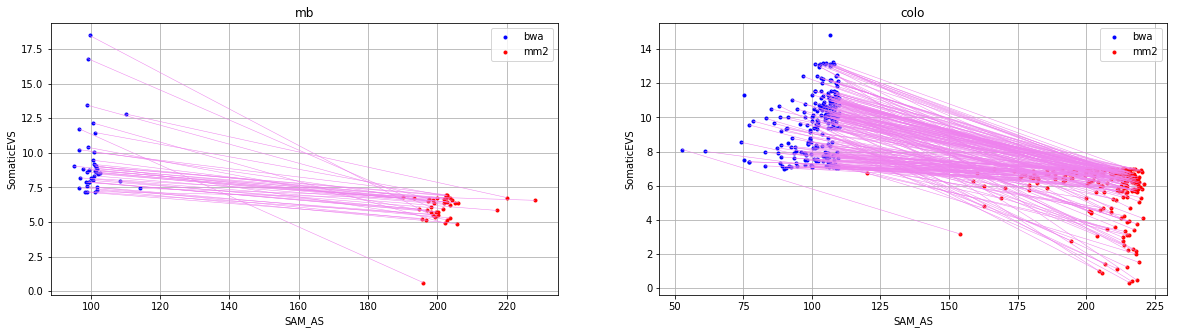

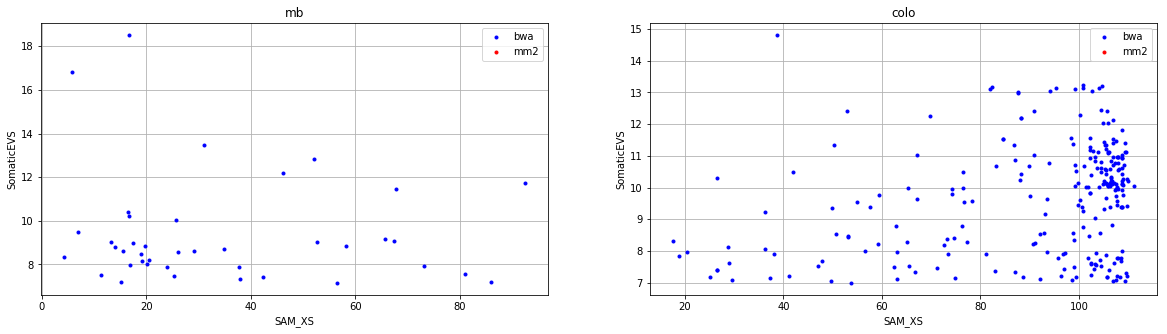

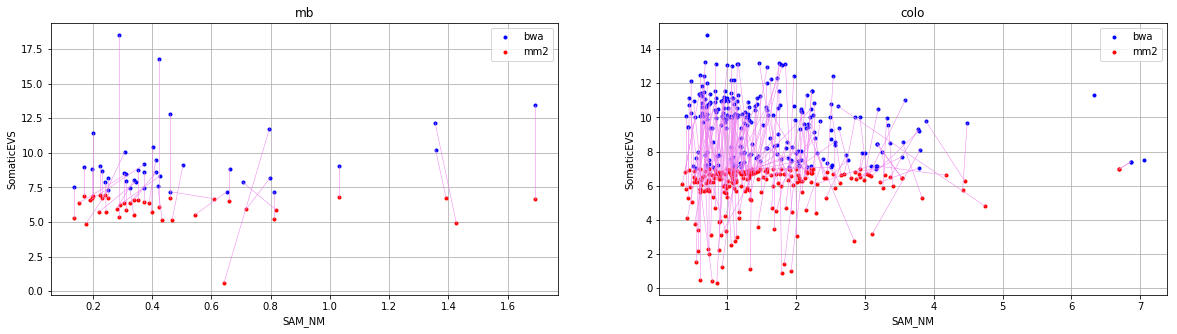

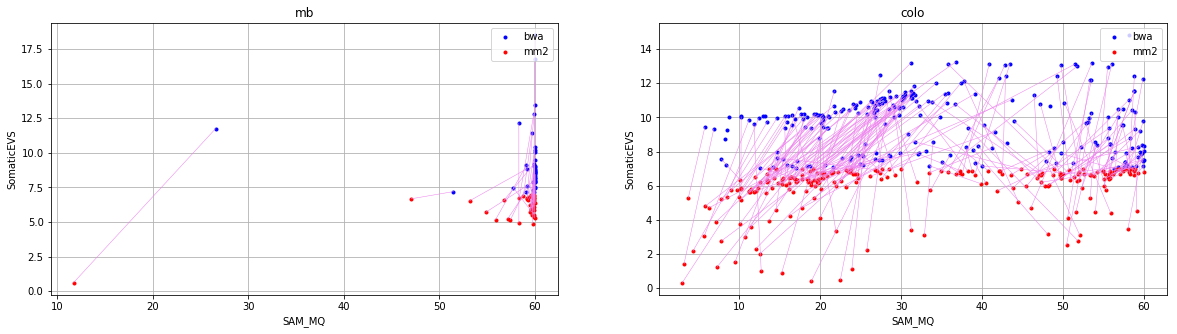

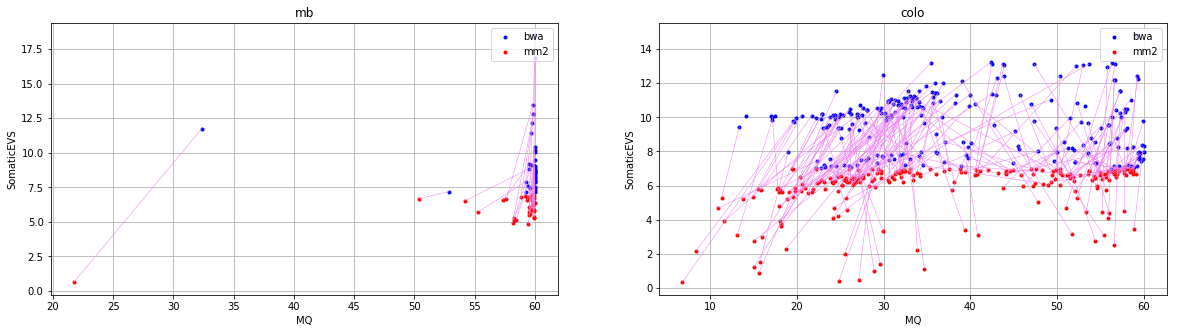

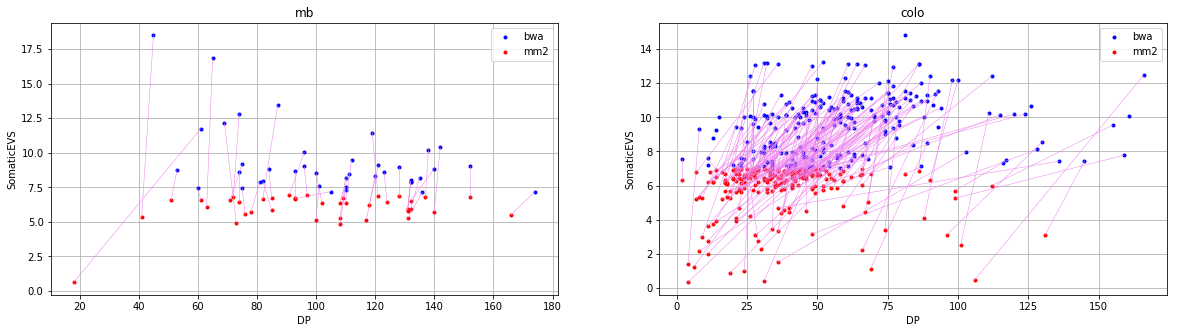

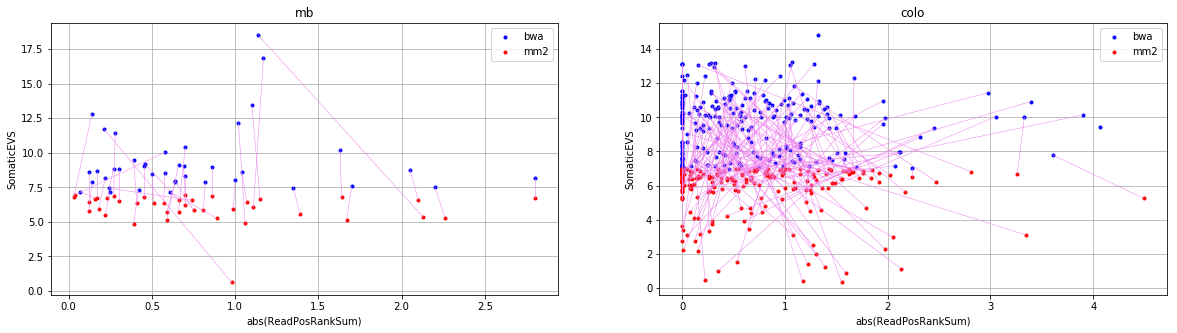

In [67]:
# For unique Strelka2+BWA FP, plotting differences with minimap2
from matplotlib import gridspec
import pandas as pd
import numpy as np

def plot_tags_to_evs(df_by_bn):
    for get_xs_df, xlabel in [
        (lambda d, aln: d[f'{aln}_TUMOR_SAM_AS'],                               'SAM_AS'),
        (lambda d, aln: d[f'{aln}_TUMOR_SAM_XS'],                               'SAM_XS'),
        (lambda d, aln: d[f'{aln}_TUMOR_SAM_NM'],                               'SAM_NM'),
        (lambda d, aln: d[f'{aln}_TUMOR_SAM_MQ'],                               'SAM_MQ'),
        (lambda d, aln: d[f'{aln}_TUMOR_MQ'],                                   'MQ'),
        (lambda d, aln: d[f'{aln}_TUMOR_DP'],                                   'DP'),
        (lambda d, aln: abs(d[f'{aln}_ReadPosRankSum']),                        'abs(ReadPosRankSum)'),
    #     (lambda d: d[f'{aln}_TUMOR_MQ'] * abs(d[f'{aln}_ReadPosRankSum']), 'MQ * abs(ReadPosRankSum)'),
    ]:
        fig = plt.figure(figsize=(20, 5))
        grid = gridspec.GridSpec(1, 2, width_ratios=[100, 100])
        for i, (bn, df) in enumerate(df_by_bn.items()):
            ax = plt.subplot(grid[i], label=bn)

            # What x is plotted - from bwa or mm2?
            xss = [get_xs_df(df, aln).tolist() for aln in ['bwa', 'mm2']]
            yss = [df[f'{aln}_SomaticEVS'].tolist() for aln in ['bwa', 'mm2']]

            for j, aln in enumerate(['bwa', 'mm2']):
                ax.plot(xss[j], yss[j], '.', c=bright_colors[j], label=f'{aln}')

            for x, ((x1, x2), (y1, y2)) in enumerate(zip(list(zip(*xss)), list(zip(*yss)))):
                ax.plot([x1, x2], [y1, y2], '-', c='violet', lw=0.5)
            ax.set_xlabel(xlabel)
            ax.set_ylabel('SomaticEVS')
            ax.set_title(label=bn)
            ax.legend(*ax.get_legend_handles_labels(), loc=1)
            plt.grid()
            
plot_tags_to_evs(tp_bwa_strelka_by_bn)

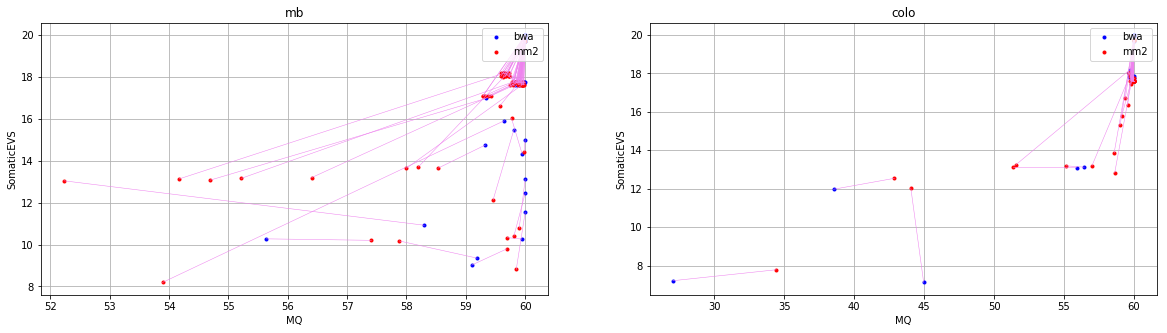

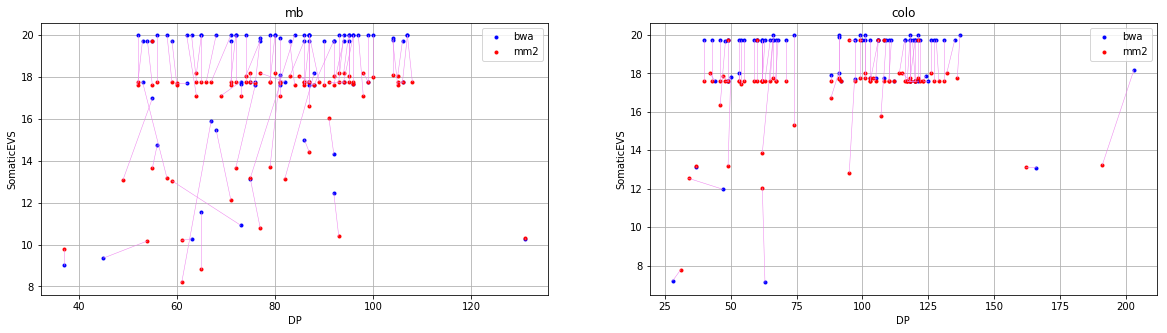

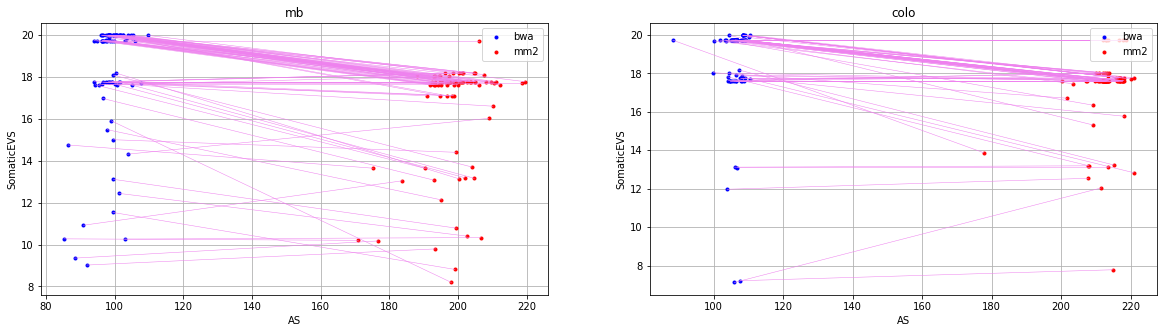

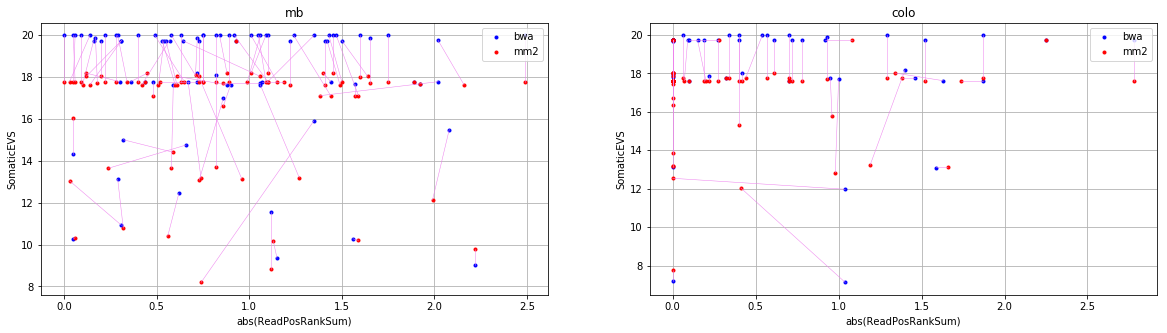

In [473]:
plot_tag_diffs(chr21_tp_strelka_by_bn)

In [479]:
# Printing average SAM and VCF flags statistics for each aligner
for bn in benchmarks_names:
    print(bn)
    for aln in ['bwa', 'mm2']:
        df = benchmark_d[bn]['df']
        if df is not None:
            for f in [
                'TUMOR_AF',   
                'TUMOR_MQ',       
                'TUMOR_DP',       
                'ReadPosRankSum', 
                'SomaticEVS',
                ]:
                mean_val = df.query('caller == "strelka2"')[f'{aln}_{f}'].mean()
                print(f'{aln} mean {f}: {mean_val}')

mb
bwa mean TUMOR_AF: 0.3579798229380515
bwa mean TUMOR_MQ: 55.488213924959965
bwa mean TUMOR_DP: 78.59909122684375
bwa mean ReadPosRankSum: -0.1640877594822893
bwa mean SomaticEVS: 13.056988420583185
mm2 mean TUMOR_AF: 0.39648169078223544
mm2 mean TUMOR_MQ: 55.80010059468706
mm2 mean TUMOR_DP: 75.6484312148029
mm2 mean ReadPosRankSum: -0.2651004469600074
mm2 mean SomaticEVS: 12.952979198016598
colo
bwa mean TUMOR_AF: 0.5635354895902278
bwa mean TUMOR_MQ: 57.391812897565586
bwa mean TUMOR_DP: 76.9117532053261
bwa mean ReadPosRankSum: -0.14781619508344807
bwa mean SomaticEVS: 17.12594378408873
mm2 mean TUMOR_AF: 0.5630403376204054
mm2 mean TUMOR_MQ: 57.97675314797414
mm2 mean TUMOR_DP: 76.61992881036109
mm2 mean ReadPosRankSum: -0.1531606598797781
mm2 mean SomaticEVS: 16.1824051219997
giab


<br>
<br>


##  Spacial distributions

In [50]:
# Plotting different fields vs. coordinates

from matplotlib.ticker import LinearLocator
from matplotlib import rc, font_manager

def get_colors(category):
    """ Return color of BWA dot, color of minimap2 dot, and color of line connecting dots
    """
    if   category == ('tp', 'tp'):  return 'purple',    'purple', 'purple'
    elif category == ('tp', 'fn'):  return 'blue',       None,     None
    elif category == ('fp', 'fp'):  return 'violet',    'violet', 'violet'
    elif category == ('fp', 'tn'):  return 'lightblue',  None,     None
    elif category == ('fn', 'tp'):  return  None,       'red',     None
    elif category == ('fn', 'fn'):  return 'green',      None,     None
    elif category == ('tn', 'fp'):  return  None,       'pink',    None
    else:                           return  None,        None,     None

## Plotting chromosome ticks
def draw_ticks(ax, restrict_to_chrom=None):
    chrom_poss = chrom_positions
    if restrict_to_chrom:
        chrom_poss = [(c, p) for c, p in chrom_positions if c in [
            str(restrict_to_chrom), 
            int_to_chrom(chrom_to_int(restrict_to_chrom) + 1)]]
    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])    
    return chrom_poss
    
## Plotting data
def plot(bn, caller, field, field_name=None, restrict_to_chrom=None, max_y=None, count_tricky_anno=True):
    print(f'Plotting {field} for {caller} by coordinate')
    df = benchmark_d[bn]['df']
    dfc = df[df['caller'] == caller]

    stats_by_cat_by_chrom = defaultdict(Counter)
    for (is_snp, category, chrom), g in dfc.groupby(['is_snp', 'category', 'chrom']):
        stats_by_cat_by_chrom[(is_snp, category)][chrom] += len(g)

    field_name = field_name or field.upper()

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, label=f'{caller}_{field}', 
                         title=f'{field_name} for variant calls from BWA (blue) vs. minimap2 (red) alignments')
    chrom_poss = draw_ticks(ax, restrict_to_chrom)
    
    modify = modify_back = lambda v: v
    if max_y:
        modify = lambda v: max_y+(-max_y)/10 if v > max_y else v
        modify_back = lambda v: max_y+(v-max_y)*10 if v > max_y else v
    
    groupby = ['bwa_t', 'mm2_t']
    if count_tricky_anno:
        groupby.append('tricky_anno')

    # Plotting dots
    for category, g in dfc.groupby(groupby):
        bwa_validate, mm2_validate = category[:2]
        tricky_anno = category[2] if count_tricky_anno else None
        bwa_color, mm2_color, line_color = get_colors((bwa_validate, mm2_validate))
        try:
            bys = g[f'bwa_{field}'].map(modify)
        except:
            raise
        mys = g[f'mm2_{field}'].map(modify)
        marker = 'x' if tricky_anno else '.'
        if bwa_color:
            ax.scatter(g['x'], bys, marker=marker, color=bwa_color)
        if mm2_color:
            ax.scatter(g['x'], mys, marker=marker, color=mm2_color)
        if line_color:
            for index, row in g.iterrows():
                by = modify(row[f'bwa_{field}'])
                my = modify(row[f'mm2_{field}'])
                ax.plot([row['x'], row['x']], [by, my], color=line_color, linewidth=1)
    
    # Adding ticks and labels
    s = stats_by_cat_by_chrom
    def _make_lbl(c):
        cs = dict(
            c_snp_t = s[True, "common_tp"][c],
            c_ind_t = s[False, "common_tp"][c],
            c_snp_f = s[True, "common_fp"][c],
            c_ind_f = s[False, "common_fp"][c],
            b_snp_t = s[True, "unique_tp_bwa"][c],
            b_ind_t = s[False, "unique_tp_bwa"][c],
            b_snp_f = s[True, "unique_fp_bwa"][c],
            b_ind_f = s[False, "unique_fp_bwa"][c],
            m_snp_t = s[True, "unique_tp_mm2"][c],
            m_ind_t = s[False, "unique_tp_mm2"][c],
            m_snp_f = s[True, "unique_fp_mm2"][c],
            m_ind_f = s[False, "unique_fp_mm2"][c],
        )
        max_snp_len = max([len(str(v)) for k, v in cs.items() if 'snp' in k])
        max_ind_len = max([len(str(v)) for k, v in cs.items() if 'ind' in k])
            
        if c == '1':
            return '\n'.join([f'{c}',
                              f'Common   T {cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'BWA uniq T {cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'MM2 uniq T {cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
        else:
            return '\n'.join([f'{c}', 
                              f'{cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'{cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'{cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'{cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'{cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'{cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
    plt.xticks([pos for c, pos in chrom_poss], 
               [_make_lbl(c) if c else '' for c, _ in chrom_poss],
              horizontalalignment='left',
              fontproperties=font_manager.FontProperties(family='monospace'))
    
    if max_y:
        ax.set_yticklabels([modify_back(l) for l in ax.get_yticks().tolist()])
        ax.plot([0, dfc['x'].max()], [max_y, max_y], color='black', linestyle='--', linewidth=1)

    plt.grid()
    return dfc, ax

Plotting TUMOR_DP for strelka2 by coordinate
Plotting NORMAL_DP for strelka2 by coordinate


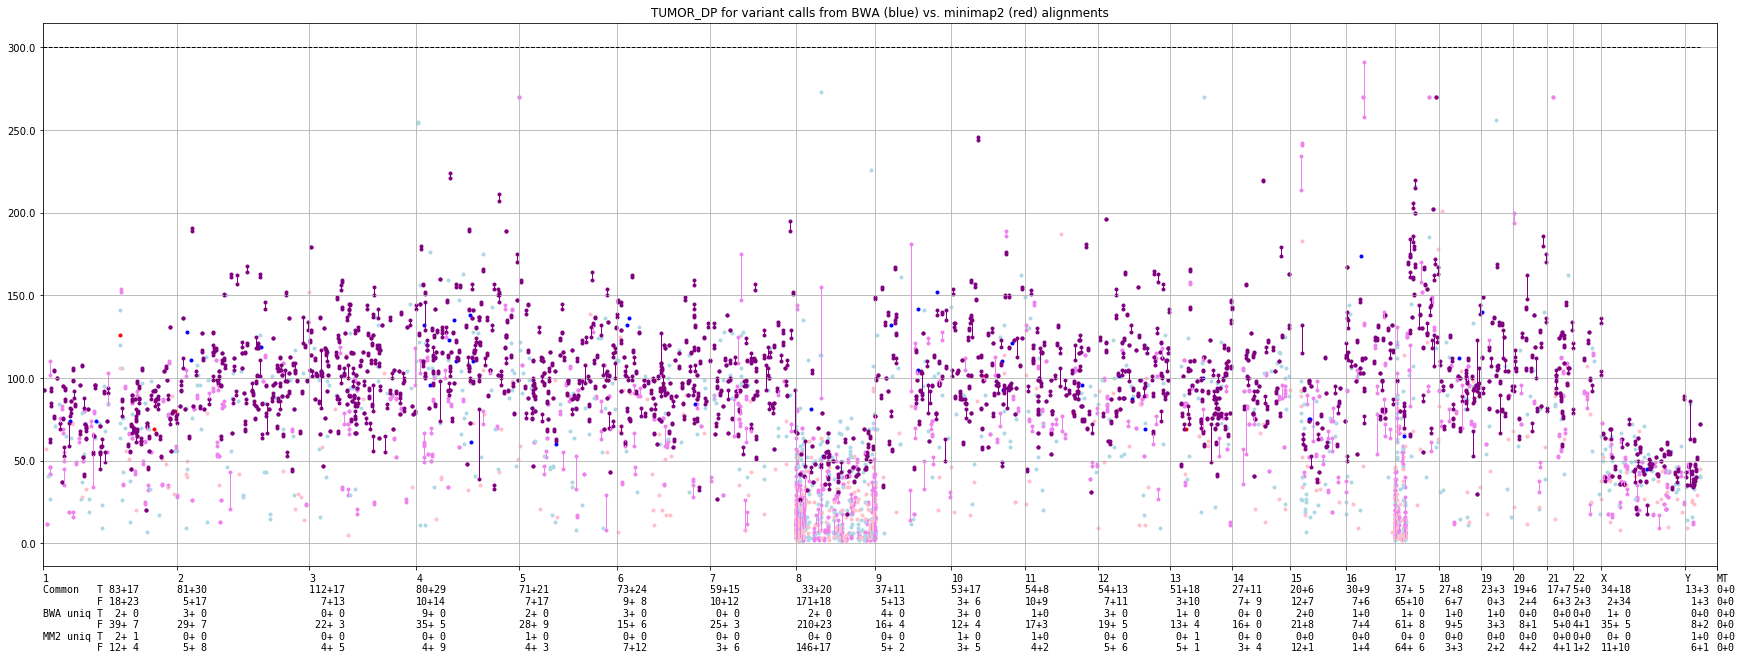

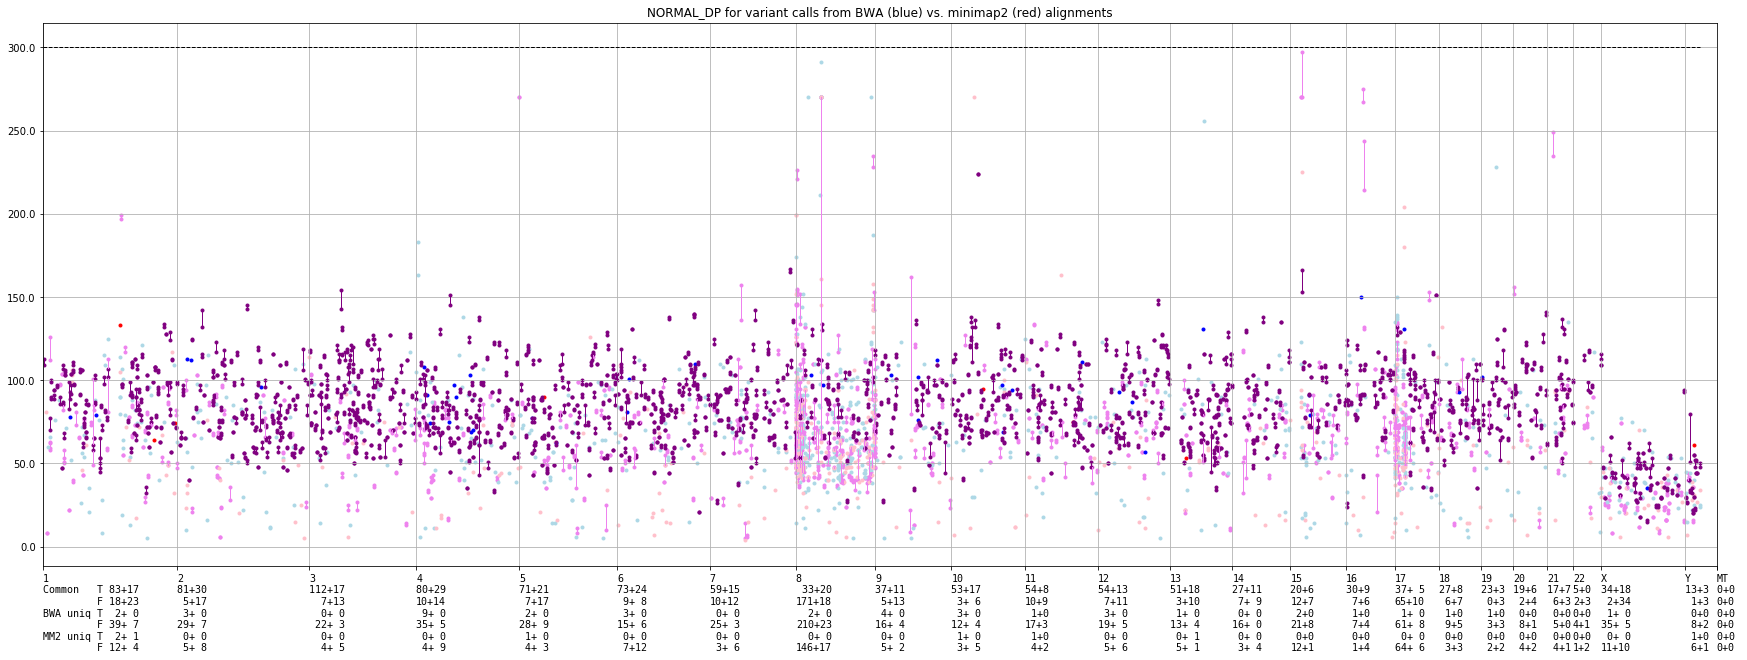

In [41]:
plot('mb', 'strelka2', 'TUMOR_DP', max_y=300, count_tricky_anno=False)
plot('mb', 'strelka2', 'NORMAL_DP', max_y=300, count_tricky_anno=False)
pass

Plotting TUMOR_MQ for strelka2 by coordinate
Plotting NORMAL_MQ for strelka2 by coordinate


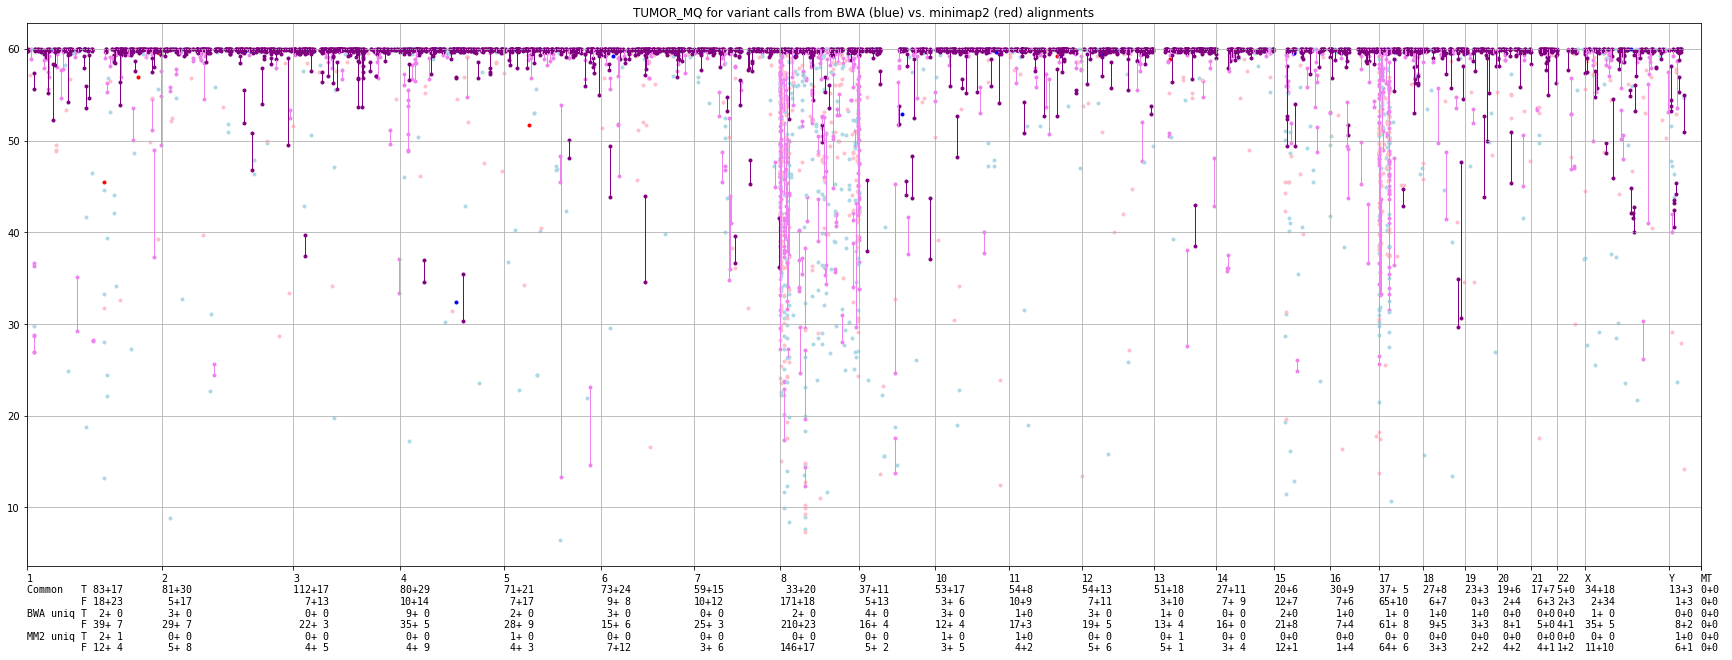

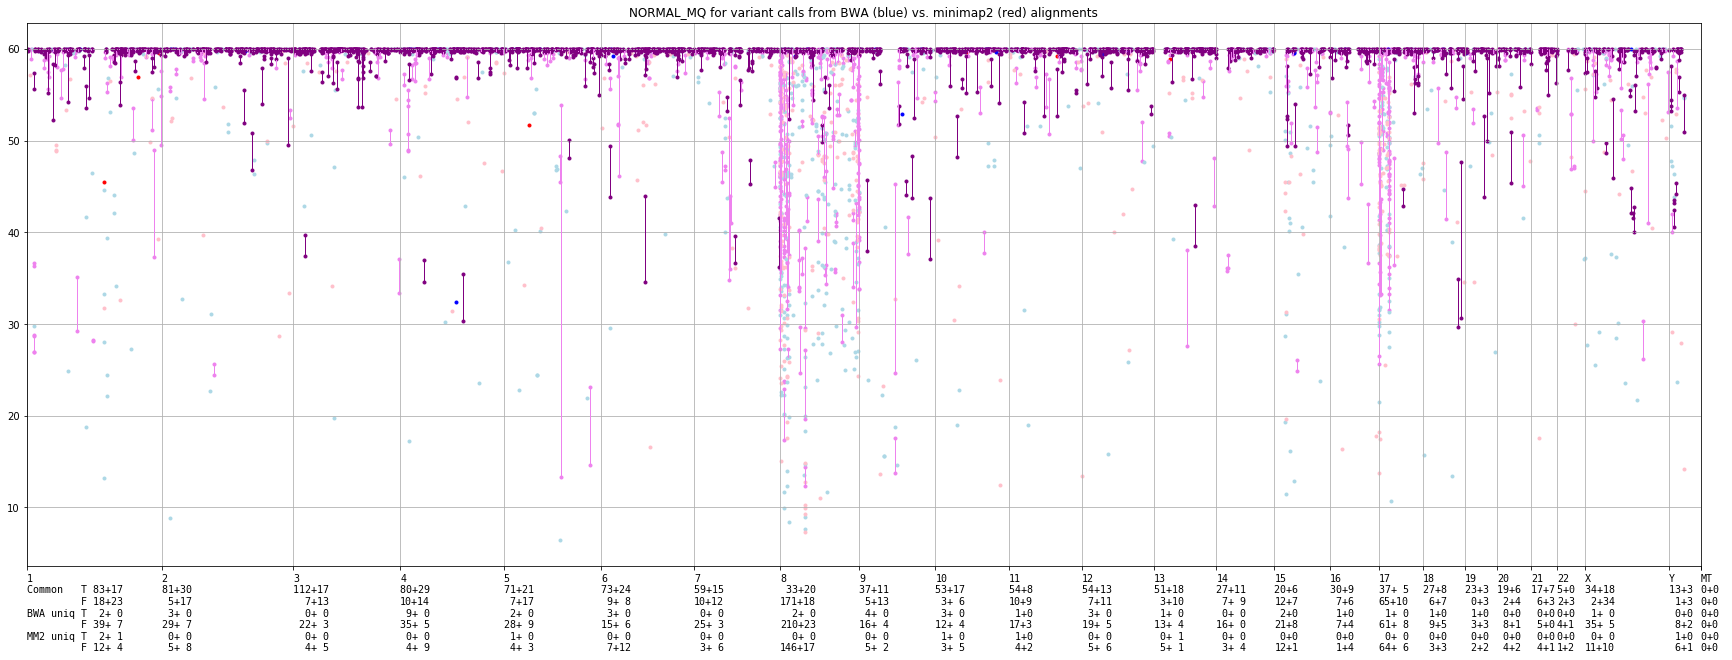

In [42]:
plot('mb', 'strelka2', 'TUMOR_MQ', count_tricky_anno=False)
plot('mb', 'strelka2', 'NORMAL_MQ', count_tricky_anno=False)
pass

<br>
<br>


##  ROC curves

In [16]:
# Plotting ROC curve and TP/FP ratios

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from ipywidgets import *

tp_colors = ['blue', 'red', 'green']
fp_colors = ['lightblue', 'pink', 'lightgreen']

def plot_roc(title, df, roc_field, start, end, step=1, label_step=5, show_values=False, filt_fn=None):
    fig = plt.figure(figsize=(20, 10))
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    plt.suptitle(f'Benchmark {title}')

    roc_ax = plt.subplot(grid[0], label=f'ROC {field}', title=f'ROC curve based on {field}')
    roc_ax.set_xlabel('TPR')
    roc_ax.set_ylabel('FPR')
    plt.grid()

    tp_fp_ax = plt.subplot(grid[1], label=f'TP and FP {field}', title=f'TP and FP based on {field}')  
    tp_fp_ax.set_xlabel(f'{field}')
    tp_fp_ax.set_ylabel('Calls')
    plt.grid()
    
    # Pre-calculation    
    max_tp = max_tp = 0
    tps_by_aln, fps_by_aln = defaultdict(list), defaultdict(list)
    for aln in ['bwa', 'mm2']:
        vals = np.arange(start, end + step, step)
        for val in vals:
            val_data = dfc[dfc[aln + '_' + field] >= val]
            
            tp = len(val_data[val_data[f'{aln}_t'] == 'tp'])
            fn = len(val_data[val_data[f'{aln}_t'] == 'fn'])
            fp = len(val_data[val_data[f'{aln}_t'] == 'fp'])

            tps_by_aln[aln].append(tp)
            fps_by_aln[aln].append(fp)
            
            called = tp + fp
            precs = tp / called if called else 0
            truth = tp + fn
            recall = tp / truth if truth else 0
    
    max_tp = max(max(vs) for vs in tps_by_aln.values())
    max_fp = max(max(vs) for vs in fps_by_aln.values())
    
    com, bwa, mm2 = [], [], []    
    for val, bwa_tp, bwa_fp, mm2_tp, mm2_fp in zip(
        vals, tps_by_aln['bwa'], fps_by_aln['bwa'], tps_by_aln['mm2'], fps_by_aln['mm2']):
        bwa.append([val, bwa_tp, bwa_fp])
        mm2.append([val, mm2_tp, mm2_fp])
        if bwa_tp == mm2_tp and bwa_fp == mm2_fp:
            com.append([val, bwa_tp, bwa_fp])

    # ROC curve plots
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '-', c='blue',   lw=0.5)
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '.', c='blue',   label=f'BWA FPR / TPR')
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '-', c='red',    lw=0.5)
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '.', c='red',    label=f'Minimap2 FPR / TPR')
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '-', c='purple', lw=0.5)
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '.', c='purple', label=f'Shared FPR / TPR')

    # TP and FP plots        
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '-', c='blue',      lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '.', c='blue',      label=f'BWA TPs')
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '-', c='lightblue', lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '.', c='lightblue', label=f'BWA FPs') 
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '-', c='red',       lw=0.5)
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '.', c='red',       label=f'Minimap2 TPs')
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '-', c='pink',      lw=0.5) 
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '.', c='pink',      label=f'Minimap2 FPs')
    tp_fp_ax.plot([p[0] for p in com], [p[1] for p in com], '.', c='purple',    label=f'Shared TPs')
    tp_fp_ax.plot([p[0] for p in com], [p[2] for p in com], '.', c='violet',    label=f'Shared FPs')

    for aln in ['bwa', 'mm2']:
        for v, fp, tp in com + bwa + mm2:
            label = f'{v}'
            if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(fp, tp))
                tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))

    delta = max_tp*0.05
    roc_ax.set_xlim([0, max_tp+delta])

    delta = max_fp*0.05
    roc_ax.set_ylim([0, max_fp+delta])
    
    delta = (end-start)*0.05
    tp_fp_ax.set_xlim([start-delta, end+delta])

    max_y = max(max_tp, max_fp)
    delta = max_y*0.05
    tp_fp_ax.set_ylim([-delta, max_y+delta])
      
    roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)

def roc_points(title, df, roc_field, start=None, end=None, step=None, label_step=None):
    print(f'{title}: calc roc points based on {roc_field}')

    start = start or min(df[roc_field])
    end = end or max(df[roc_field])
    step = step or (0.01 if (end-start)/10<1 else 1)
    label_step = step * 10
    print(f'  calculating for {roc_field} thresholds from {start} to {end} with step of {step}')

    tps, fps, precs, recalls = [], [], [], []

    vals = np.arange(start, end + step, step)
    for val in vals:
        val_df = bdf[bdf[roc_field] >= val]
        tp = len(val_df[val_df['typ'] == 'tp'])
        fn = len(val_df[val_df['typ'] == 'fn'])
        fp = len(val_df[val_df['typ'] == 'fp'])

        tps.append(tp)
        fps.append(fp)
        called = tp + fp
        precs.append(tp / called if called else 0)
        truth = tp + fn
        recalls.append(tp / truth if truth else 0)
    return vals, tps, fps, label_step
    
def plot_roc_from_points(roc_pts_by_f_by_bn):
    for j, (bn, roc_pts_by_f) in enumerate(roc_pts_by_f_by_bn.items()):
#        print(f'Plotting {bn}')
        fig = plt.figure(figsize=(20, 10*(1+len(roc_pts_by_f))//2))
        grid = gridspec.GridSpec(2, (1+len(roc_pts_by_f))//2)
        plt.suptitle(f'Benchmark {bn}')

        roc_ax = plt.subplot(grid[0], label=f'ROC', title=f'ROC curve')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')

        for i, (f, [vals, tps, fps, label_step]) in enumerate(roc_pts_by_f.items()):
 #           print(f'   Plotting {f}')
            # ROC curve plot
            roc_ax.plot(tps, fps, '-', c=tp_colors[i], lw=0.5)
            roc_ax.plot(tps, fps, '.', c=tp_colors[i], label=f'{f}')
            plt.grid()
            
            # TP/FP plot
            tp_fp_ax = plt.subplot(grid[1+i], label=f'TP v FP', title=f'TP v FP curve by {f}')
            tp_fp_ax.set_xlabel(f'{f}')
            tp_fp_ax.set_ylabel('Calls')

            tp_fp_ax.plot(vals, tps, '-', c=tp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, tps, '.', c=tp_colors[i], label=f'{f} TPs')
            tp_fp_ax.plot(vals, fps, '-', c=fp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, fps, '.', c=fp_colors[i], label=f'{f} FPs')
            plt.grid()
    
            tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)
            plt.grid()

            # Labels
            for v, tp, fp in zip(vals, tps, fps):
                label = f'{v}'
                if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                    roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(tp, fp))
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
            plt.grid()
        
        roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
        plt.grid()

In [ ]:
# Filter with panel of normal, evaluate?

In [ ]:
# Calling roc_points and plot_roc_from_points

roc_pts_by_f_by_bn = defaultdict(dict)
for bn in benchmarks_names:
    roc_pts_by_f_by_bn[bn]['TUMOR_AF'] = roc_points(bn, benchmarks_d[bn]['df'], 'TUMOR_AF')
    roc_pts_by_f_by_bn[bn]['TUMOR_DP'] = roc_points(bn, benchmarks_d[bn]['df'], 'TUMOR_DP', end=500)
    roc_pts_by_f_by_bn[bn]['TUMOR_MQ'] = roc_points(bn, benchmarks_d[bn]['df'], 'TUMOR_MQ')

def _plot(af, dp, mq):
    min_by_f = {
        'TUMOR_AF': af,
        'TUMOR_DP': dp,
        'TUMOR_MQ': mq,
    }
    r = defaultdict(dict)
    for bn, roc_pts_by_f in roc_pts_by_f_by_bn.items():
        for f, (vals, tps, fps, label_step) in roc_pts_by_f.items():
            triplets = [(v, tp, fp) for (v, tp, fp) in zip(vals, tps, fps) if v >= min_by_f[f]]
            vals, tps, fps = zip(*triplets)
            r[bn][f] = vals, tps, fps, label_step

    plot_roc_2(r)

interact(_plot, af=0.01, dp=10, mq=20)    

In [ ]:
# Plotting ROC based on COMMON

def _is_common(x):
    return 1 if (x['bwa_t'] in ['tp', 'fp'] and x['mm2_t'] in ['tp', 'fp']) else 0

for bn, b in benchmarks_d:
    df = b['df']
    df['common'] = df.apply(_is_common, axis=1)
    for clr in b['callers']:
        df = df.query(f'caller == "{clr}"')
        plot_roc(f'{bn} {caller}', df, 'common', start=0, end=1, step=1, label_step=1, show_values=False)
        pass

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


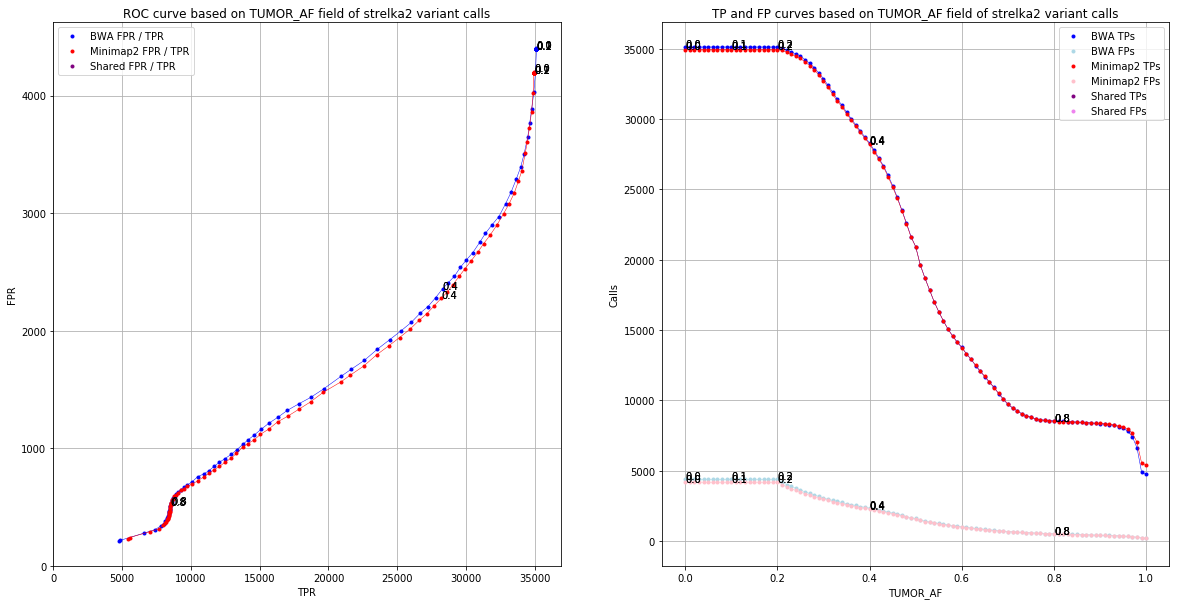

In [28]:
# Plotting ROC for Strelka2 SomaticEVS

def filt_fn(v):
    r = True
    if v['bwa_TUMOR_AF'] and v['bwa_TUMOR_AF'] < 0.2:
        r = False
    if v['bwa_TUMOR_DP'] and v['bwa_TUMOR_DP'] < 23:
        r = False
    if v['mm2_TUMOR_AF'] and v['mm2_TUMOR_AF'] < 0.2:
        r = False
    if v['mm2_TUMOR_DP'] and v['mm2_TUMOR_DP'] < 23:
        r = False
    return r
       
plot_roc('strelka2', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.1, show_values=False, filt_fn=filt_fn)
pass

In [ ]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.1, show_values=False)
pass

In [ ]:
dfc = df[df['caller'] == 'strelka2']
d = dfc[dfc['called_with_mm2'] == True]

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})

pd.set_option('display.max_columns', None)
g2 = sns.jointplot(x="mm2_TUMOR_AF", y="mm2_TUMOR_DP", data=d, kind="kde", kde_kws={'clip':((0, 1), (0, 200))});
#g2.set(xlim=(0, 1), ylim=(0, 200))
#g = sns.distplot(dfc_mm2['mm2_TUMOR_AF'][1000:], rug=True, bins=50)
#g.set(xlim=(0, 1))

In [ ]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'SomaticEVS', 0, 10, 0.1)
pass

In [ ]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'ReadPosRankSum', 0, 4, 0.1)
pass

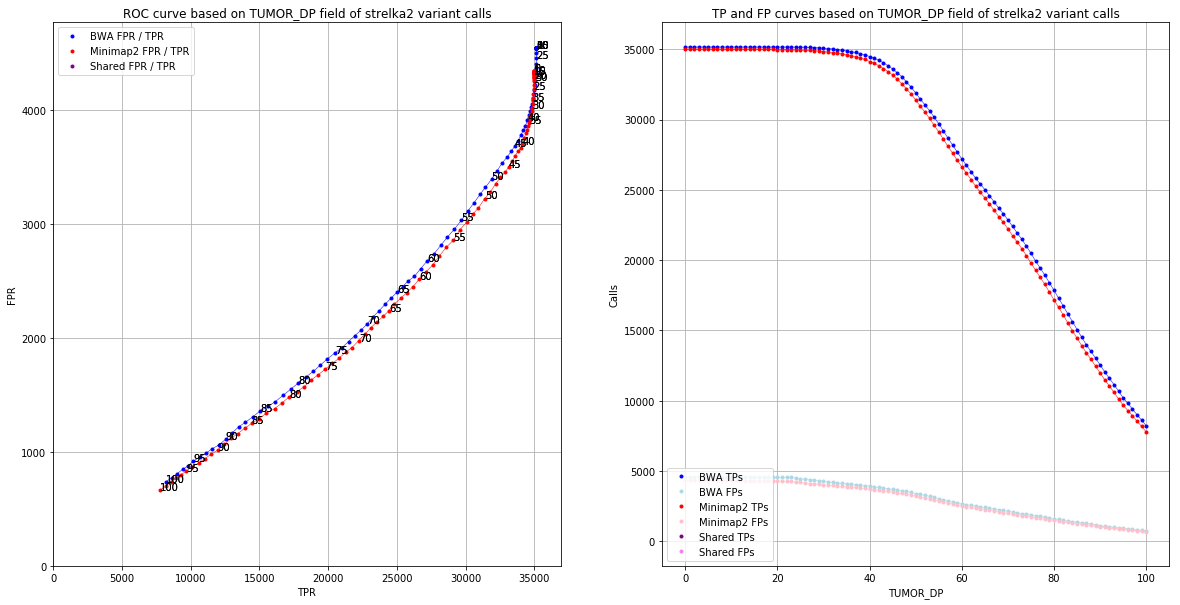

In [12]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_DP', 0, 100, 1)
pass

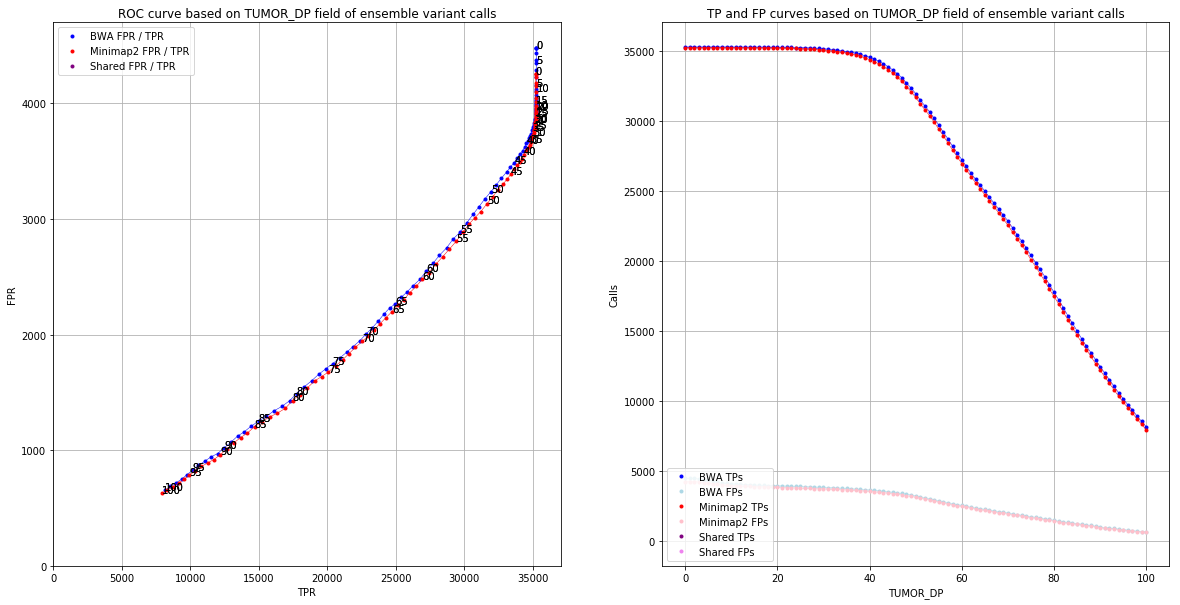

In [7]:
# Strelka2 DP ROC curve
plot_roc('ensemble', 'TUMOR_DP', 0, 100, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'TUMOR_DP', 1, 100, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'TUMOR_DP', 1, 100, 1)
pass

*Plotting variants with X axis as a genome position, and Y axis as a feature (MQ, DP, etc).*
- red dot represent a variant called with minimap2
- blue dot represent a variant called wit BWA
- variants called with both aligners are connected with vertical lines
- pale colors represent false positives, bright colors correspond to true positives
- green dots at the bottom represent shared false negatives (i.e. true variants not called with any aligner)
- those that overlap with low complexity or high/low tricky regions, scatterred with x; others scatterred with .

In [ ]:
plot('strelka2', 'TUMOR_MQ')
#plot('strelka2', 'NORMAL_MQ')
pass

# Annotate dots with gene names:
# for _, r in df[df[f'bwa_mq'] < 20][df[f'bwa_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'bwa_mq']))
# for _, r in df[df[f'mm2_mq'] < 20][df[f'mm2_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'mm2_mq']))

# Observations:
# - Chromosome 8: many bwa and minimap FP, but only few are shared.
# 
# TODO: 
# - ROC and other validatiopn stats based on MQ
# - Figure out high depth regions

In [ ]:
## Subset unique variants and make minibams to explore in IGV

def subset_unique(caller, aligner):
    strelka = df[df['caller'] == caller]
    uniq_tp = strelka[strelka['category'] == f'unique_tp_{aligner}']
    lbls = uniq_tp['label'].tolist()

    inp_vcf = VCF(vcfs[caller][aligner]['tp'])
    out_path = f'{caller}_uniq_to_{aligner}_tp.vcf'
    with open(out_path, 'w') as vcf_f, open(out_path + '.bed', 'w') as bed_f:
        vcf_f.write(inp_vcf.raw_header)
        for rec in inp_vcf:
            lbl = f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}'
            if lbl in lbls:
                vcf_f.write(str(rec))
                bed_f.write(f'{rec.CHROM}\t{rec.POS-100}\t{rec.POS+100}\n')
    return out_path

In [23]:
vcf_bwa = subset_unique('strelka2', 'bwa')

In [24]:
vcf_mm2 = subset_unique('strelka2', 'mm2')

In [25]:
def subset_bam(beds, caller):
    beds = ' '.join(beds)
    !cat {beds} | bedtools sort -i stdin | bedtools merge -i stdin > {caller}_unique.bed

subset_bam([vcf_bwa + '.bed', vcf_mm2 + '.bed'], 'strelka2')

cat strelka2_uniq_to_bwa_tp.vcf.bed strelka2_uniq_to_mm2_tp.vcf.bed | bedtools sort -i stdin | bedtools merge -i stdin > strelka2_unique.bed


In [45]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>